### Starbucks Capstone Challenge : Data Analysis and Visualization
Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

Final Advice
Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).


Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

portfolio.json

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)
profile.json

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income
transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record

This is a Capstone Project for Udacity Data Scientist Nano Degree Program.  In this project I will be analyzing simulated data provided by Starbucks about customers and offers.

In [1]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

#import data set
portfolio_df = pd.read_json("portfolio.json", lines = True)
profile_df = pd.read_json("profile.json", lines = True)
transcript_df = pd.read_json("transcript.json", lines = True)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Portfolio data analysis and cleaning:
Portfolio data details:
1. id (string) - offer id 
2. offer_type (string) - type of offer ie BOGO, discount, informational 
3. difficulty (int) - minimum required spend to complete an offer 
4. reward (int) - reward given for completing an offer 
5. duration (int) - time for offer to be open, in days 
6. channels (list of strings)


In [3]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Cleaning Portfolio dataset
Actions:
1. replace channels column with 4 columns representing each communication channel (web, email, mobile, social) 
2. replace offer id with easily understandable number format
3. change unit of measurement for duration to hours from days
4. rename id column to offer_id
5. Rename reward to 'offer reward'

In [4]:
#1. creating columns for each channel and replacing channels column
portfolio_df = portfolio_df.drop('channels', axis=1).join(portfolio_df.channels.str.join('|').str.get_dummies())

#2. create unique values for each offerID and store in a dictionary for use in other datasets
offer_id = list(portfolio_df['id'])
value_id = list(range(1,11,1))
offer_id_dict = {offer_id[i]: int(value_id[i]) for i in range(len(value_id))}                              
portfolio_df['id'] = portfolio_df['id'].map(offer_id_dict)

#3. change unit for duration to hours
portfolio_df['duration'] = portfolio_df['duration'] * 24

#4. rename id coulmn to offer_id
portfolio_df = portfolio_df.rename(columns = {'id': 'offer_id'})

#5. rename reward coulmn to offer_reward
portfolio_df = portfolio_df.rename(columns = {'reward': 'offer_reward'})


In [5]:
#cleaned portfolio dataset
portfolio_df.head(10)

,offer_reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,168,bogo,1,1,1,1,0
1,10,10,120,bogo,2,1,1,1,1
2,0,0,96,informational,3,1,1,0,1
3,5,5,168,bogo,4,1,1,0,1
4,5,20,240,discount,5,1,0,0,1
5,3,7,168,discount,6,1,1,1,1
6,2,10,240,discount,7,1,1,1,1
7,0,0,72,informational,8,1,1,1,0
8,5,5,120,bogo,9,1,1,1,1
9,2,10,168,discount,10,1,1,0,1


Profile data analysis and cleaning
Profile data details:
1. gender: (categorical) M, F, O, or null
2. age: (numeric) missing value encoded as 118
3. id: (string/hash)
4. became_member_on: (date) format YYYYMMDD
5. income: (numeric)

In [6]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Cleaning Profile dataset
Actions:
1. Here we can see that gender and income has 2175 missing values, also missing values for age has been encoded as 118(if we count these it comes out to be exactly 2175, so it is safe to assume that it is for entries who have missing gender and income). We will remove these values. We will check if our assumption is right before deleting the entries
2. replace offer id with easily understandable number format
3. replace became_member_on column with member_for column indicating for how many monhts the custer is a member
4. rename id column to member_id

In [7]:
#here we see that for age = 118 there is no value in gender and income so our assumption was right, we will delete these entries
profile_df[profile_df['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [8]:
#1. delete all members with Nan as income
profile_df.dropna(subset = ["income"], inplace=True)
        
#2. create unique values for each member id and store in a dictionary for use in other datasets
profile_id = list(profile_df['id'])
member_id = list(range(1,14826,1))
profile_id_dict = {profile_id[i]: int(member_id[i]) for i in range(len(member_id))}                              
profile_df['id'] = profile_df['id'].map(profile_id_dict)

#3. replace became_member_on column with member_for column indicating for how many monhts the custer is a member
profile_df['became_member_on']= profile_df['became_member_on'].astype(str)
profile_df['member_date'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')
today = pd.to_datetime ('today')
profile_df['member_for_months']  = ((today - profile_df.member_date)/np.timedelta64(1, 'M'))
profile_df['member_for_months'] = profile_df['member_for_months'].astype(int)
profile_df= profile_df.drop(['became_member_on','member_date'], axis = 1)
#4. rename id column to member_id
profile_df = profile_df.rename(columns = {'id': 'member_id'})

Exploratory data analysis for profile dataset

Text(0.5, 1.0, 'Income Histogram')

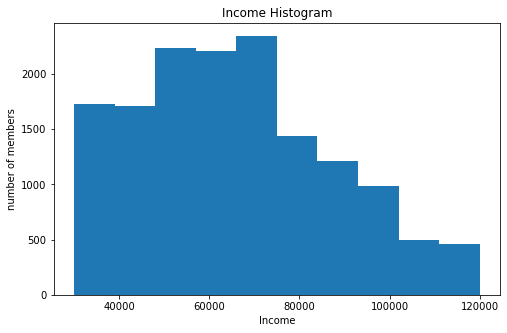

In [9]:
#income distribution for members
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile_df['income'], 10)
plt.xlabel('Income')
plt.ylabel('number of members')
plt.title('Income Histogram')

In [10]:
#income range
profile_df.describe()

,age,member_id,income,member_for_months
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,7413.000000,65404.991568,45.581788
std,17.383705,4279.753206,21598.299410,13.774133
min,18.000000,1.000000,30000.000000,28.000000
25%,42.000000,3707.000000,49000.000000,35.000000
50%,55.000000,7413.000000,64000.000000,40.000000
75%,66.000000,11119.000000,80000.000000,55.000000
max,101.000000,14825.000000,120000.000000,88.000000


Text(0.5, 1.0, 'Age Histogram')

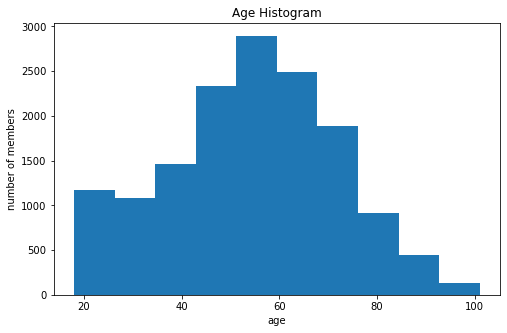

In [11]:
#Age distribution for members
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile_df['age'], 10)
plt.xlabel('age')
plt.ylabel('number of members')
plt.title('Age Histogram')

In [12]:
#correlation between Age and income
profile_df['age'].corr(profile_df['income'])
#there is not correlation between age and income

0.30670278856125516

Text(0.5, 1.0, 'Distribution of members, when they joined the app ')

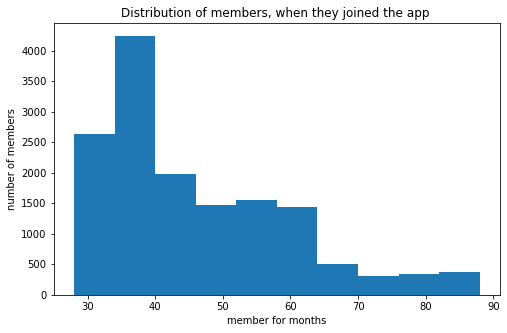

In [13]:
#distribution for members loyalty based in number of month when they joined the app
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile_df['member_for_months'], 10)
plt.xlabel('member for months')
plt.ylabel('number of members')
plt.title('Distribution of members, when they joined the app ')

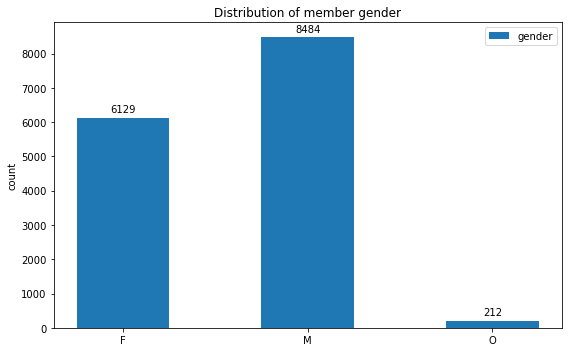

In [14]:
#gender distribution for members
gender = profile_df.groupby('gender')['member_id'].count()
gender_cat = profile_df.gender.unique()
x = np.arange(len(gender_cat))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize = (8,5))
rects1 = ax.bar(x, gender, width, label='gender')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('Distribution of member gender')
ax.set_xticks(x)
ax.set_xticklabels(gender_cat, rotation = 0)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=15, labelsize=15)
plt.rc('font', size=10)
autolabel(rects1)
fig.tight_layout()
plt.show()

#### More Data cleaning:(categorize age, income and loyalty years based on 4 quartiles)
5. divide age in 4 groups: 1. young , 2. middle, 3. senior, 4. old
6. divide income in 4 groups 1. lower, 2. avg , 3. above_avg, 4.rich
7. divide loyalty in 4 groups 1. very_recent, 2 recent , 3. seasoned, 4.vintage

In [15]:
#5. Divide loyalty categories

profile_df['loyalty'] = 'no_value'
profile_df['age_cat'] = 'no_value'
profile_df['income_cat'] = 'no_value'

for i in range(len(profile_df['member_for_months'])):
    if profile_df['member_for_months'].iloc[i] < 35:
        profile_df['loyalty'].iloc[i] = 'very_recent'
    elif profile_df['member_for_months'].iloc[i] < 40:
        profile_df['loyalty'].iloc[i] = 'recent'
    elif profile_df['member_for_months'].iloc[i] < 54:
        profile_df['loyalty'].iloc[i] = 'seasoned'
    else:
        profile_df['loyalty'].iloc[i] = 'vintage'

#5. Divide age categories
for i in range(len(profile_df['age'])):
    if profile_df['age'].iloc[i] < 42:
        profile_df['age_cat'].iloc[i] = 'young'
    elif profile_df['age'].iloc[i] < 55:
        profile_df['age_cat'].iloc[i] = 'middle'
    elif profile_df['age'].iloc[i] < 66:
        profile_df['age_cat'].iloc[i] = 'senior'
    else:
        profile_df['age_cat'].iloc[i] = 'old'
        
profile_df = profile_df.rename(columns = {'age': 'age_num','age_cat': 'age'})

#6 Divide income in 4 categories
for i in range(len(profile_df['income'])):
    if profile_df['income'].iloc[i] < 49000:
        profile_df['income_cat'].iloc[i] = 'lower'
    elif profile_df['income'].iloc[i] < 64000:
        profile_df['income_cat'].iloc[i] = 'avg'
    elif profile_df['income'].iloc[i] < 80000:
        profile_df['income_cat'].iloc[i] = 'above_avg'
    else:
        profile_df['income_cat'].iloc[i] = 'rich'

profile_df = profile_df.rename(columns = {'income': 'income_num','income_cat': 'income'})


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
#cleaned profile dataset
profile_df.head()

,gender,age_num,member_id,income_num,member_for_months,loyalty,age,income
1,F,55,1,112000.0,41,seasoned,senior,rich
3,F,75,2,100000.0,43,seasoned,old,rich
5,M,68,3,70000.0,31,very_recent,old,above_avg
8,M,65,4,53000.0,34,very_recent,senior,avg
12,M,58,5,51000.0,37,recent,senior,avg


Transcript data Analysis and cleaning:

1. person: (string/hash)
2. event: (string) offer received, offer viewed, transaction, offer completed value: (dictionary) different values depending on event type
3. Value:
    1. offer id: (string/hash) not associated with any "transaction"
    2. amount: (numeric) money spent in "transaction"
    3. reward: (numeric) money gained from "offer completed" 
4. time: (numeric) hours after start of test

In [17]:
transcript_df.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


Cleaning transcript dataset:
1. replace person column name with member_id and map values form member_id_dict
2. replace value column with 3 columns(offer_id, amount and reward) and put respective values in the columns. map offer_id with offer_id_dict 

In [18]:
#1. replace person with member id from profile data set, using profile_id_dict
transcript_df['person'] = transcript_df['person'].map(profile_id_dict)
transcript_df.dropna(subset = ['person'], inplace = True)
transcript_df = transcript_df.rename(columns = {'person': 'member_id'})

#2. Create one column for each event type and put offerId , transaction amount or offer received amount in the column as value
transcript_df['offer_id'] = transcript_df['value'].apply(lambda x: x.get('offer_id'))
transcript_df['offer id'] = transcript_df['value'].apply(lambda x: x.get('offer id'))
#merge the 'offer_id' and 'offer id' columns
transcript_df['transaction_amount'] = transcript_df['value'].apply(lambda x: x.get('amount'))
transcript_df['transaction_reward'] = transcript_df['value'].apply(lambda x: x.get('reward'))
transcript_df['offer_id'] = transcript_df.apply(lambda x: x['offer id'] if x['offer_id'] == None else x['offer_id'], axis = 1)
transcript_df = transcript_df.drop(['value', 'offer id'], axis = 1)
transcript_df.fillna(0, inplace = True)
transcript_df['offer_id'] = transcript_df['offer_id'].map(offer_id_dict)
transcript_df.fillna(0, inplace = True)


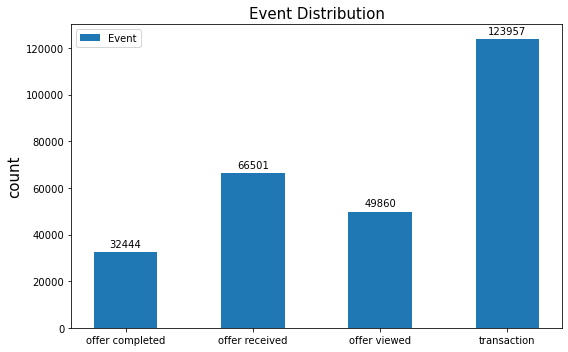

In [20]:
#Exploratory analysis for Transaction data
#Distribution of Events for all transaction dataset
events= transcript_df.groupby('event')['member_id'].count()
event_name = np.sort(transcript_df.event.unique())
x = np.arange(len(event_name))  # the label locations
width = 0.50  # the width of the bars
fig, ax = plt.subplots(figsize = (8,5))
rects1 = ax.bar(x, events, width, label='Event')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('Event Distribution')
ax.set_xticks(x)
ax.set_xticklabels(event_name, rotation = 0)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=15, labelsize=15)
plt.rc('font', size=10)
autolabel(rects1)
fig.tight_layout()
plt.show()

An offer is successful only if it is received by member, viewed by member within time duration and completed by member in time duration. if an offer is not viewed by member but he/she still makes purchases and completes the offer then that offer is not successful.

In [21]:
transcript_df.head()

,member_id,event,time,offer_id,transaction_amount,transaction_reward
0,2.0,offer received,0,4.0,0.0,0.0
2,3.0,offer received,0,10.0,0.0,0.0
5,4.0,offer received,0,9.0,0.0,0.0
7,5.0,offer received,0,3.0,0.0,0.0
8,6.0,offer received,0,5.0,0.0,0.0


In [22]:
#lets merge the three datasets into one
#row which are specific to transaction events will not have any value in the coulmns pertaining to offer details, 
#we will impute them later if required
final_df = pd.merge(transcript_df, profile_df , on ='member_id')
final_df = pd.merge(final_df, portfolio_df , how='left', on ='offer_id')
final_df

,member_id,event,time,offer_id,transaction_amount,transaction_reward,gender,age_num,income_num,member_for_months,...,age,income,offer_reward,difficulty,duration,offer_type,email,mobile,social,web
0,2.0,offer received,0,4.0,0.00,0.0,F,75,100000.0,43,...,old,rich,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
1,2.0,offer viewed,6,4.0,0.00,0.0,F,75,100000.0,43,...,old,rich,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
2,2.0,transaction,132,0.0,19.89,0.0,F,75,100000.0,43,...,old,rich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,offer completed,132,4.0,0.00,5.0,F,75,100000.0,43,...,old,rich,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
4,2.0,transaction,144,0.0,17.78,0.0,F,75,100000.0,43,...,old,rich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,14080.0,offer viewed,504,3.0,0.00,0.0,M,47,94000.0,38,...,middle,rich,0.0,0.0,96.0,informational,1.0,1.0,0.0,1.0
272758,14080.0,offer received,576,2.0,0.00,0.0,M,47,94000.0,38,...,middle,rich,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0
272759,14080.0,offer viewed,576,2.0,0.00,0.0,M,47,94000.0,38,...,middle,rich,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0
272760,10391.0,offer received,576,2.0,0.00,0.0,F,58,78000.0,50,...,senior,above_avg,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0


In [23]:
#creating a copy of final_df on which we will be doing all the analysis work
final_df1 = final_df.copy()

In [24]:
final_df1

,member_id,event,time,offer_id,transaction_amount,transaction_reward,gender,age_num,income_num,member_for_months,...,age,income,offer_reward,difficulty,duration,offer_type,email,mobile,social,web
0,2.0,offer received,0,4.0,0.00,0.0,F,75,100000.0,43,...,old,rich,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
1,2.0,offer viewed,6,4.0,0.00,0.0,F,75,100000.0,43,...,old,rich,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
2,2.0,transaction,132,0.0,19.89,0.0,F,75,100000.0,43,...,old,rich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,offer completed,132,4.0,0.00,5.0,F,75,100000.0,43,...,old,rich,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
4,2.0,transaction,144,0.0,17.78,0.0,F,75,100000.0,43,...,old,rich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,14080.0,offer viewed,504,3.0,0.00,0.0,M,47,94000.0,38,...,middle,rich,0.0,0.0,96.0,informational,1.0,1.0,0.0,1.0
272758,14080.0,offer received,576,2.0,0.00,0.0,M,47,94000.0,38,...,middle,rich,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0
272759,14080.0,offer viewed,576,2.0,0.00,0.0,M,47,94000.0,38,...,middle,rich,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0
272760,10391.0,offer received,576,2.0,0.00,0.0,F,58,78000.0,50,...,senior,above_avg,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0


Exploratory data analysis of this merged dataset

Total transaction done in one months time by members in various age groups and income groups
age            young     middle     senior        old
income                                               
above_avg   95641.06  120239.60  128738.68  129320.40
avg        107340.46   94493.39   78664.96   82635.85
lower      101294.01   48111.04   44760.58   46480.11
rich        25140.62  155364.09  224904.90  251812.65
----------------------------------------------------
Count of members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg    795     953     961  1013
avg         1111     957     819   875
lower       1454     799     658   713
rich         131     938    1263  1385
-----------------------------------------------------
Per person spent on starbucks by app members in various age groups and income groups
age        young  middle  senior    old
income                                 
above_avg  120.0   1

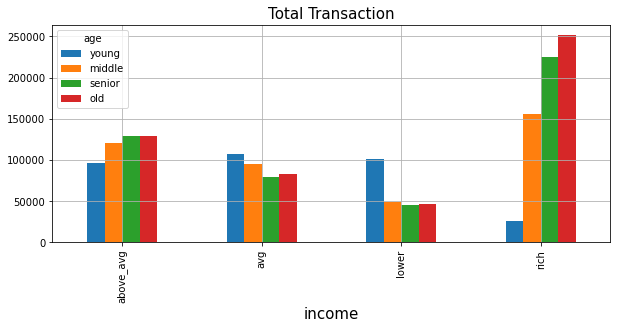

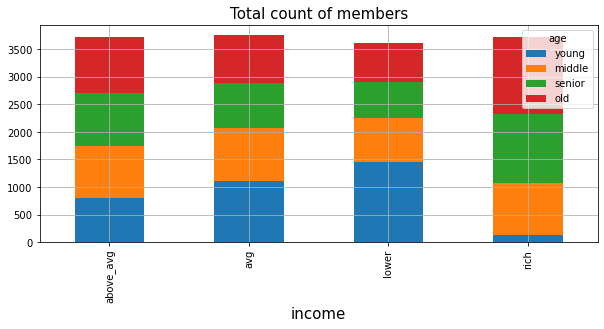

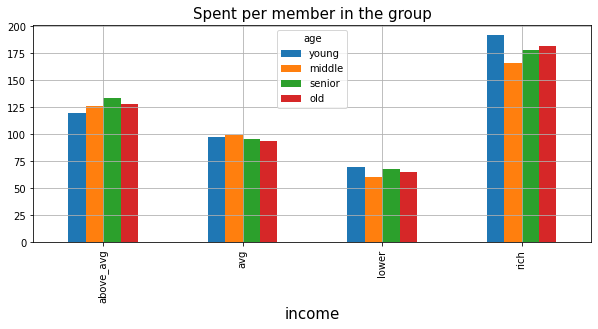

In [25]:
#Demographic data on which group of member make most transaction
#based on income and age
print("Total transaction done in one months time by members in various age groups and income groups")
income_expend = final_df1.groupby(['income', 'age'])['transaction_amount'].sum().unstack()
income_expend = income_expend[['young', 'middle', 'senior', 'old']]
income_expend.plot.bar(figsize=(10,4), title="Total Transaction", grid=True)
print(income_expend)
print("----------------------------------------------------")
print("Count of members in various age groups and income groups")
demo_count = profile_df.groupby(['income', 'age'])['member_id'].count().unstack()
demo_count = demo_count[['young', 'middle', 'senior', 'old']]
demo_count.plot.bar(stacked=True , figsize=(10,4), title="Total count of members", grid=True)
print(demo_count)
print('-----------------------------------------------------')
print("Per person spent on starbucks by app members in various age groups and income groups")
#expenditure per member
exp_per_member = np.round(income_expend/demo_count , decimals = 0)
print(exp_per_member)
exp_per_member.plot.bar(figsize=(10,4), title="Spent per member in the group", grid=True)

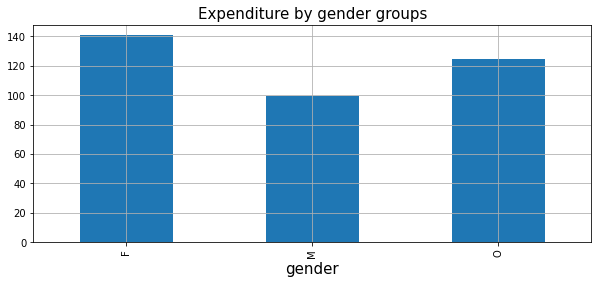

In [26]:
# Expenditure done by various groups different genders 
gender_expense = final_df1.groupby('gender')['transaction_amount'].sum()
gender_count = profile_df.groupby('gender')['member_id'].count()
per_person_gender_expense= gender_expense/gender_count
per_person_gender_expense.plot.bar(figsize=(10,4), title="Expenditure by gender groups", grid=True)
#Females tend to expend more by 40% compared to males

Total transaction done in one months time by members in various age groups and gender groups
age            young     middle     senior        old
income                                               
above_avg   95641.06  120239.60  128738.68  129320.40
avg        107340.46   94493.39   78664.96   82635.85
lower      101294.01   48111.04   44760.58   46480.11
rich        25140.62  155364.09  224904.90  251812.65
----------------------------------------------------
Count of members in various age groups and gender groups
age        young  middle  senior   old
income                                
above_avg    795     953     961  1013
avg         1111     957     819   875
lower       1454     799     658   713
rich         131     938    1263  1385
-----------------------------------------------------
Per person spent on starbucks by app members in various age groups and gender groups
age     young  middle  senior    old
gender                              
F       126.0   141.0   14

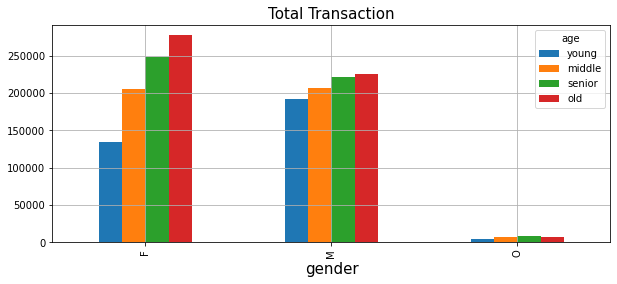

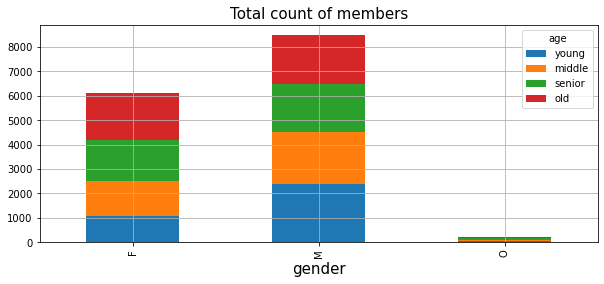

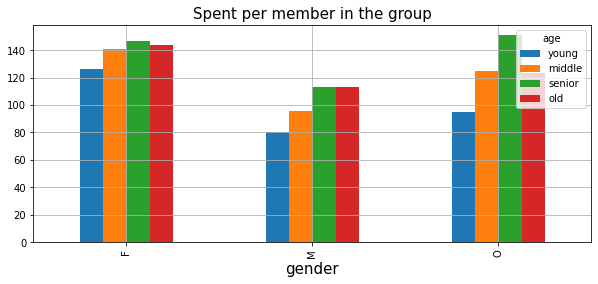

In [27]:
#Demographic data on which group of member make most transaction
#based on gender and age
print("Total transaction done in one months time by members in various age groups and gender groups")
gender_expend = final_df1.groupby(['gender', 'age'])['transaction_amount'].sum().unstack()
gender_expend = gender_expend[['young', 'middle', 'senior', 'old']]
gender_expend.plot.bar(figsize=(10,4), title="Total Transaction", grid=True)
print(income_expend)
print("----------------------------------------------------")
print("Count of members in various age groups and gender groups")
gender_count = profile_df.groupby(['gender', 'age'])['member_id'].count().unstack()
gender_count = gender_count[['young', 'middle', 'senior', 'old']]
gender_count.plot.bar(stacked=True , figsize=(10,4), title="Total count of members", grid=True)
print(demo_count)
print('-----------------------------------------------------')
print("Per person spent on starbucks by app members in various age groups and gender groups")
#expenditure per member
exp_per_member_gender_age = np.round(gender_expend/gender_count , decimals = 0)
print(exp_per_member_gender_age)
exp_per_member_gender_age.plot.bar(figsize=(10,4), title="Spent per member in the group", grid=True)

Which demography group views the offers that they get in app, this wont reflect if the user saw the add on time. But this will give a decent Idea about which group is more active on the app

Total offer recieved by members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg   3603    4235    4338  4473
avg         4989    4279    3728  3961
lower       6556    3558    2944  3198
rich         594    4151    5712  6182
----------------------------------------------------
Total offer viewed by members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg   2617    3437    3359  3433
avg         3592    3443    2974  3187
lower       4527    2373    2017  2197
rich         563    3277    4271  4593
-----------------------------------------------------
Percentage of offers viewed by app members in various age groups and income groups
age        young  middle  senior    old
income                                 
above_avg  72.63   81.16   77.43  76.75
avg        72.00   80.46   79.77  80.46
lower      69.05   66.69   68.51  68.70


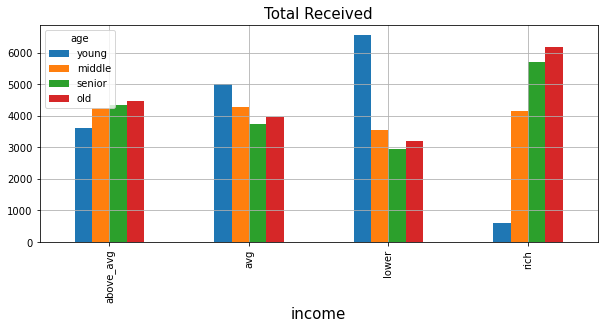

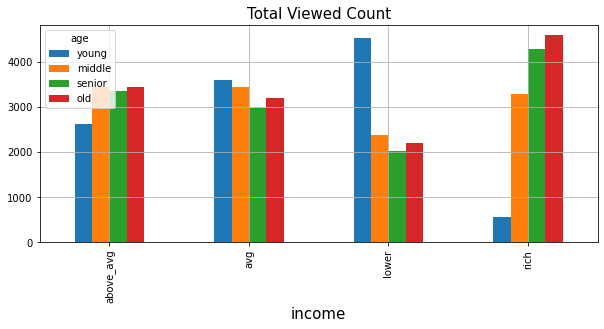

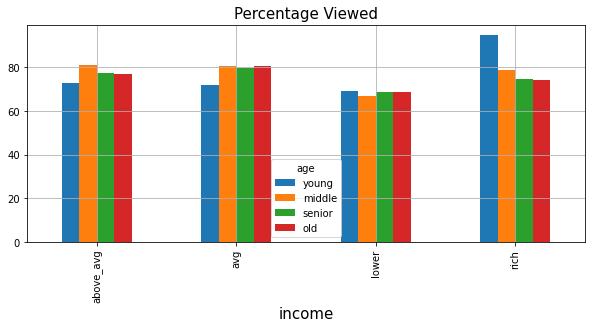

In [28]:
offer_viewed = final_df1[final_df1['event'] == 'offer viewed']
offer_received = final_df1[final_df1['event'] == 'offer received']
print("Total offer recieved by members in various age groups and income groups")
received = offer_received.groupby(['income', 'age'])['member_id'].count().unstack()
received = received[['young', 'middle', 'senior', 'old']]
received.plot.bar(figsize=(10,4), title="Total Received", grid=True)
print(received)
print("----------------------------------------------------")
print("Total offer viewed by members in various age groups and income groups")
view = offer_viewed.groupby(['income', 'age'])['member_id'].count().unstack()
view = view[['young', 'middle', 'senior', 'old']]
view.plot.bar(figsize=(10,4), title="Total Viewed Count", grid=True)
print(view)
print('-----------------------------------------------------')
print("Percentage of offers viewed by app members in various age groups and income groups")
#expenditure per member
percentage_view = np.round((view/received) * 100 , decimals = 2)
print(percentage_view)
percentage_view.plot.bar(figsize=(10,4), title="Percentage Viewed", grid=True)

Which demography group completes the offers that they get in app and view it, this wont reflect if the user viewed the offer on time. But this will give a decent Idea about which group is more active on the app

Total offer completed by members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg   1629    2243    2442  2381
avg         2195    2012    1727  1828
lower       2367    1219    1039  1156
rich         361    2505    3506  3834
-----------------------------------------------------
Percentage of offers completed which were viewed by app members in various age groups and income groups


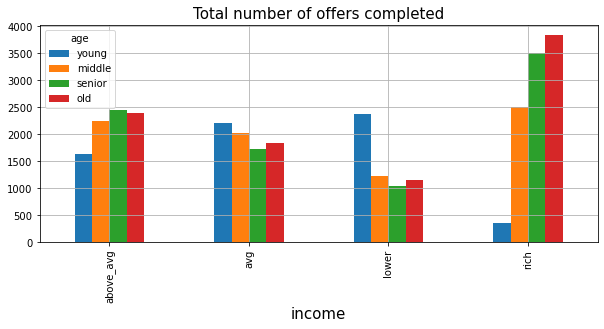

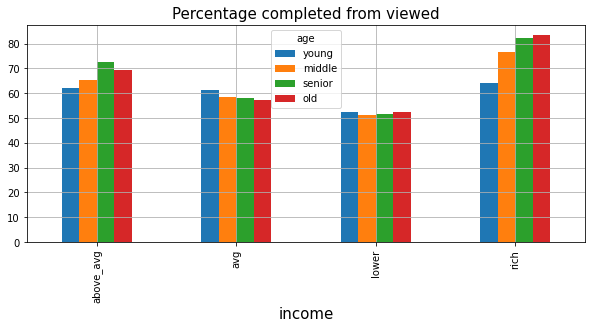

In [29]:
offer_completed = final_df1[final_df1['event'] == 'offer completed']
print("Total offer completed by members in various age groups and income groups")
completed = offer_completed.groupby(['income', 'age'])['member_id'].count().unstack()
completed = completed[['young', 'middle', 'senior', 'old']]
completed.plot.bar(figsize=(10,4), title="Total number of offers completed", grid=True)
print(completed)
print('-----------------------------------------------------')
print("Percentage of offers completed which were viewed by app members in various age groups and income groups")
#expenditure per member
percentage_view_complete = np.round((completed/view) * 100 , decimals = 2)
percentage_view_complete
percentage_view_complete.plot.bar(figsize=(10,4), title="Percentage completed from viewed", grid=True)


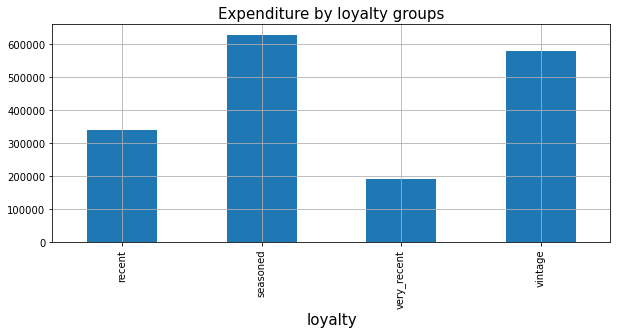

In [30]:
expenditure_loyalty = final_df1.groupby(['loyalty'])['transaction_amount'].sum()
expenditure_loyalty.plot.bar(figsize = (10,4), title= "Expenditure by loyalty groups" , grid=True)

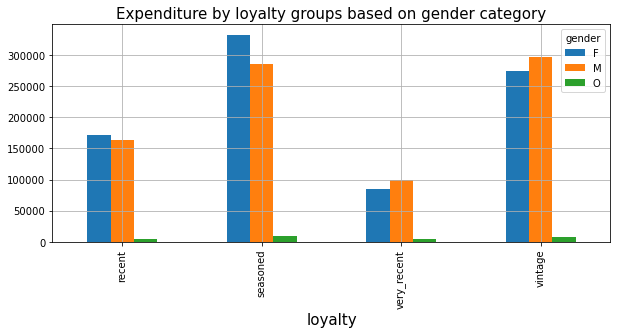

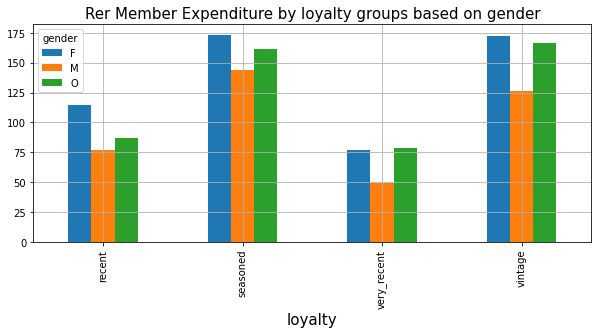

In [31]:
#transaction details based loyalty and gender 
loyalty_expense = final_df1.groupby(['loyalty', 'gender'])['transaction_amount'].sum().unstack()
loyalty_expense.plot.bar(figsize = (10,4), title= "Expenditure by loyalty groups based on gender category" , grid=True)
gender_count_loyalty = profile_df.groupby(['loyalty', 'gender'])['member_id'].count().unstack()
per_loyalty_gender_expense = np.round(loyalty_expense/gender_count_loyalty , decimals = 2)
per_loyalty_gender_expense.plot.bar(figsize=(10,4), title="Rer Member Expenditure by loyalty groups based on gender", grid=True)

age,young,middle,senior,old
loyalty,,,,
recent,69517.75,78136.27,92079.73,100065.65
seasoned,110997.85,150249.97,172722.73,193440.77
very_recent,44220.11,43731.26,50340.64,51004.89
vintage,104680.44,146090.62,161926.02,165737.70


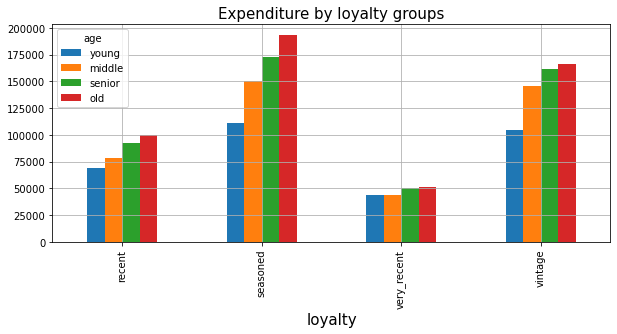

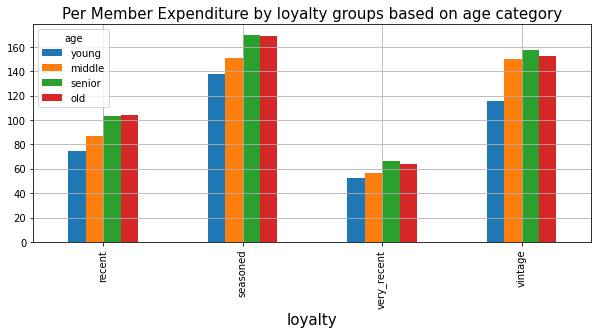

In [32]:
#transaction details based loyalty and age 
loyalty_expense = final_df1.groupby(['loyalty', 'age'])['transaction_amount'].sum().unstack()
loyalty_expense = loyalty_expense[['young', 'middle', 'senior', 'old']]
loyalty_expense.plot.bar(figsize=(10,4), title="Expenditure by loyalty groups", grid=True)
age_count_loyalty = profile_df.groupby(['loyalty', 'age'])['member_id'].count().unstack()
age_count_loyalty = age_count_loyalty[['young', 'middle', 'senior', 'old']]
per_loyalty_age_expense = np.round(loyalty_expense/age_count_loyalty , decimals = 2)
per_loyalty_age_expense.plot.bar(figsize=(10,4), title="Per Member Expenditure by loyalty groups based on age category", grid=True)

loyalty_expense

Before we dive into which offers were completed properly and which were not. Lets do some analysis on which type of offer is prefered by which member demography most. We will do this one by one for all four : 1. Income , 2, gender, 3 Age and 4. Loyalty

In [33]:
#By Gender
#offer_completed
offers_gender = offer_completed.groupby(['gender', 'offer_type'])['member_id'].count().unstack()
offers_gender

offer_type,bogo,discount
gender,,
F,7501,7976
M,7512,8954
O,245,256


In [34]:
gender_count= profile_df.groupby('gender')['gender'].count()

In [35]:
#per member bogo and discount offers used
y = offers_gender['discount']/gender_count
x = offers_gender['bogo']/gender_count
print(x, y)

gender
F    1.223854
M    0.885431
O    1.155660
dtype: float64 gender
F    1.301354
M    1.055398
O    1.207547
dtype: float64


In [36]:
#Offer completion percentage for various offers
#number of offers sent
offers = transcript_df.groupby(['offer_id', 'event'])['member_id'].count().unstack()
offers = offers.drop(['transaction'], axis = 1)
offers = offers.drop(index =0 )

In [37]:
offers['view_perc'] = np.round(((offers['offer viewed']/offers['offer received']) * 100), decimals = 1)
offers['complete_perc'] = np.round(((offers['offer completed']/offers['offer received']) * 100), decimals = 1)
offers

event,offer completed,offer received,offer viewed,view_perc,complete_perc
offer_id,,,,,
1.0,3657.0,6683.0,5901.0,88.3,54.7
2.0,3310.0,6593.0,6329.0,96.0,50.2
3.0,NaN,6657.0,3487.0,52.4,NaN
4.0,4188.0,6685.0,3499.0,52.3,62.6
5.0,3386.0,6726.0,2215.0,32.9,50.3
6.0,4886.0,6655.0,6379.0,95.9,73.4
7.0,5003.0,6652.0,6407.0,96.3,75.2
8.0,NaN,6643.0,5873.0,88.4,NaN
9.0,4103.0,6576.0,6310.0,96.0,62.4


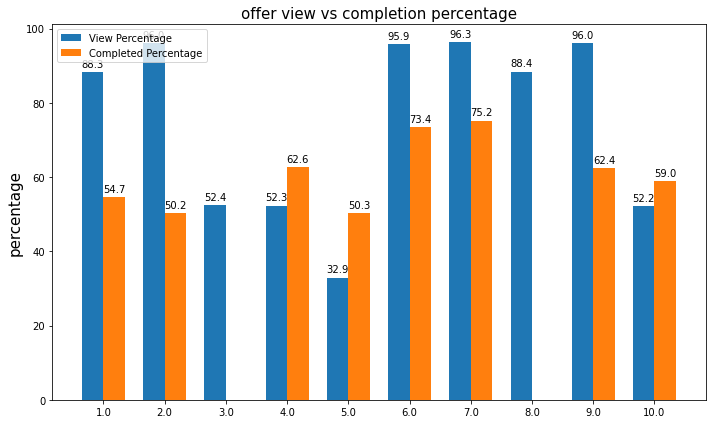

In [38]:
offer_idss = offers.index
x = np.arange(len(offer_idss))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2 , offers['view_perc'], width, label='View Percentage')
rects2 = ax.bar(x + width/2 , offers['complete_perc'], width, label='Completed Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('percentage')
ax.set_title('offer view vs completion percentage')
ax.set_xticks(x)
ax.set_xticklabels(offer_idss, rotation = 0)
ax.legend()
def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

plt.rc('axes', titlesize=15, labelsize=15)
plt.rc('font', size=10)
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

This is the result from raw dataset, here all the offers with completed and viewed flag has been considered. You can see that there is no offer complete for informational offers(3,8). For all of these offer completed several will be where customer didnot see the offer at all or he was it late after he/she has already taken benefit form the offer. This dataset in no ways gives an accurate picture but we can see here that conversion from offer view to complete is between 60-65% considering all offers are send equally. Once we have fatored in other conditions which define a successful offer completion this graph will be helpful. 

Give the demographic description of customers who spent the most? (removing O gender from the analysis)

In [39]:
tran_member = final_df1.groupby('member_id')['transaction_amount'].sum()
tran_member

member_id
1.0         77.01
2.0        159.27
3.0         57.73
4.0         36.43
5.0         15.62
            ...  
14821.0     20.03
14822.0     25.97
14823.0     39.74
14824.0    189.67
14825.0    143.02
Name: transaction_amount, Length: 14825, dtype: float64

In [40]:
profile_trans_df = profile_df.copy()
profile_trans_df['total_transactions'] = list(tran_member)
profile_trans_df

,gender,age_num,member_id,income_num,member_for_months,loyalty,age,income,total_transactions
1,F,55,1,112000.0,41,seasoned,senior,rich,77.01
3,F,75,2,100000.0,43,seasoned,old,rich,159.27
5,M,68,3,70000.0,31,very_recent,old,above_avg,57.73
8,M,65,4,53000.0,34,very_recent,senior,avg,36.43
12,M,58,5,51000.0,37,recent,senior,avg,15.62
...,...,...,...,...,...,...,...,...,...
16995,F,45,14821,54000.0,30,very_recent,middle,avg,20.03
16996,M,61,14822,72000.0,29,very_recent,senior,above_avg,25.97
16997,M,49,14823,73000.0,46,seasoned,middle,above_avg,39.74
16998,F,83,14824,50000.0,57,vintage,old,avg,189.67


In [41]:
profile_trans_df = profile_trans_df.drop(profile_trans_df[profile_trans_df['gender']=='O'].index, axis = 0)

In [42]:
demo_spend_most = profile_trans_df.groupby(['gender', 'age', 'income' ])['total_transactions'].sum().unstack()
demo_count = profile_trans_df.groupby(['gender', 'age', 'income'])['member_id'].count().unstack()

In [43]:
demo_spend_most

income         above_avg       avg     lower       rich
gender age                                             
F      middle   56987.29  43597.66  15850.95   88544.37
       old      69579.13  36036.10  21772.16  150073.83
       senior   64741.46  33681.71  17345.49  131697.21
       young    41874.79  44813.00  37111.45    9988.40
M      middle   61440.67  49613.40  31405.31   63632.87
       old      57903.18  44137.93  24258.94   99578.17
       senior   60775.32  44381.63  26338.47   90256.67
       young    52669.35  60686.81  62884.68   14927.46

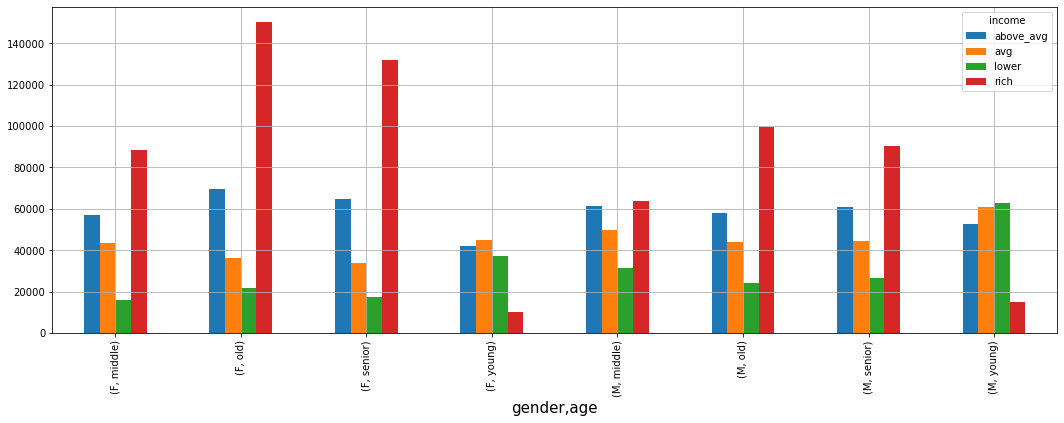

In [44]:
demo_spend_most.plot.bar(figsize = (18,6), grid = True)

Preparing dataset for model.....
Offer journey :In the transcript dataset we have four event status. An offer may go through three of these status(received, viewed and complete). Transaction gives details about all monetary transactions and these transactions may have been triggered after influence from any of the offers or they can be independent purchases. They can also partially linked to offer influence and partial a normal purchase. Either ways , if an offer is sent to a customer , a offer complete event is triggered as soon as the difficulty level for that offer is met within the time duration limit. So we can safely conclude that not all all offer complete event were influenced by offer.
We will consider only those offers successfully complete with meet below two conditions:
Offer view in Time: Once offer in received, offer is viewed by customer within time duration.
Offer completed transaction: Once offer view has happened, offer complete event is triggered between view time and offer duration.

For all other cases where offer view happened after offer complete or offer complete happened without offer view ever happening will be considered unsuccessful offers. Here, for informational offers, it is not possible to find if purchases were made because of them as there is no offer complete tag for these. For those we will consider offer view flag only, but we are not doing any analysis for these offer in this project. 

In [45]:
#inserting a new index coulmn to identify the row
final_df1.insert(0, 'index_new', np.arange(0,272762,1))
def success_flag(profile_df, final_df1):
    """this function returns success_indexs_number, view_index_number values for all transcripts which corresponds to offer_received and are categorized as
    successful orders"""
    customer_id = profile_df['member_id'].unique()
    success_indexs_number = []
    view_index_number = []
    #loop through all customer IDs
    for i in range(len(customer_id)):
        user_id= customer_id[i]
        #extract transactions associated with customer from transcripts data
        user_transcript_data = final_df1[final_df1['member_id'] ==user_id]
        #extract all the rows for offer received, completed and viewed
        offer_received_data = user_transcript_data[user_transcript_data['event'] == 'offer received']
        offer_viewed_data = user_transcript_data[user_transcript_data['event'] == 'offer viewed']
        offer_completed_data = user_transcript_data[user_transcript_data['event'] == 'offer completed']
        # loop through each offer received entry
        for j in range(offer_received_data.shape[0]):
            #extarct one offer ID
            success_flag = False
            offer_id = offer_received_data.iloc[j]['offer_id']
            print(offer_id)
            ind_number = offer_received_data.iloc[j]['index_new']
            # extract duration in hours an offer is valid from offer_recieved_data
            duration_hours = offer_received_data.iloc[j]['duration']
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[j]['time']
            end_time = start_time + duration_hours
            #get all such offer_id rows, and compare if there is any occurance where both offer view and then offer complete is hapenning
            all_offers_view_this_id = offer_viewed_data[offer_viewed_data['offer_id'] == offer_id]
            all_offers_complete_this_id = offer_completed_data[offer_completed_data['offer_id'] == offer_id]
            for k in range(all_offers_view_this_id.shape[0]):
                offer_view_time = all_offers_view_this_id.iloc[k]['time']
                offer_viewed_intime = np.logical_and(offer_view_time >= start_time,offer_view_time <= end_time)               
                if offer_viewed_intime == False:
                    continue
                view_index_number.append(ind_number)
                if all_offers_complete_this_id.empty:
                    success_flag = False
                else:
                    for t in range(all_offers_complete_this_id.shape[0]):
                        offer_complete_time = all_offers_complete_this_id.iloc[t]['time']
                        offer_completed_intime = np.logical_and(offer_complete_time >= offer_view_time, offer_complete_time <= end_time)
                        if offer_completed_intime == True:
                            success_flag = True
                            break
                        else:
                            success_flag = False
                    
            if (success_flag == True):
                success_indexs_number.append(ind_number)

    return success_indexs_number, view_index_number

indx_numbers, view_indx_numbers = success_flag(profile_df, final_df1)

4.0
3.0
4.0
8.0
1.0
9.0
10.0
3.0
4.0
7.0
9.0
4.0
10.0
4.0
9.0
7.0
3.0
6.0
7.0
5.0
2.0
8.0
1.0
9.0
5.0
10.0
5.0
1.0
5.0
10.0
5.0
7.0
6.0
6.0
6.0
7.0
5.0
1.0
8.0
5.0
4.0
6.0
4.0
3.0
4.0
1.0
8.0
6.0
6.0
6.0
5.0
10.0
1.0
5.0
5.0
3.0
1.0
3.0
8.0
3.0
7.0
2.0
8.0
7.0
2.0
7.0
3.0
5.0
10.0
5.0
2.0
4.0
4.0
10.0
7.0
10.0
5.0
6.0
4.0
3.0
5.0
2.0
5.0
4.0
7.0
8.0
10.0
8.0
4.0
9.0
6.0
1.0
6.0
8.0
2.0
10.0
2.0
4.0
1.0
2.0
2.0
6.0
3.0
5.0
10.0
8.0
4.0
9.0
6.0
4.0
8.0
1.0
9.0
4.0
4.0
2.0
3.0
4.0
8.0
4.0
1.0
7.0
8.0
5.0
6.0
8.0
7.0
9.0
10.0
6.0
10.0
1.0
5.0
4.0
6.0
2.0
3.0
2.0
10.0
2.0
9.0
6.0
4.0
1.0
6.0
4.0
5.0
1.0
4.0
8.0
2.0
3.0
9.0
7.0
8.0
9.0
2.0
3.0
5.0
4.0
6.0
10.0
1.0
4.0
10.0
1.0
10.0
2.0
8.0
1.0
4.0
5.0
5.0
6.0
4.0
8.0
6.0
10.0
4.0
10.0
6.0
5.0
2.0
1.0
5.0
2.0
7.0
9.0
5.0
3.0
1.0
7.0
5.0
8.0
10.0
7.0
9.0
6.0
6.0
7.0
10.0
7.0
1.0
6.0
5.0
8.0
3.0
2.0
2.0
6.0
5.0
9.0
9.0
2.0
10.0
6.0
8.0
10.0
4.0
6.0
6.0
7.0
9.0
8.0
5.0
8.0
8.0
2.0
9.0
1.0
10.0
8.0
5.0
1.0
4.0
6.0
1.0
10.0
8.0
10.0
2.0
2.0
4.0
1.

9.0
1.0
2.0
4.0
8.0
1.0
6.0
10.0
3.0
8.0
3.0
4.0
5.0
6.0
4.0
3.0
5.0
5.0
1.0
8.0
2.0
10.0
7.0
8.0
5.0
10.0
2.0
4.0
7.0
9.0
6.0
9.0
4.0
5.0
8.0
3.0
1.0
1.0
8.0
5.0
4.0
2.0
4.0
10.0
8.0
7.0
5.0
5.0
5.0
4.0
9.0
8.0
10.0
4.0
7.0
2.0
2.0
3.0
7.0
1.0
7.0
4.0
10.0
1.0
8.0
5.0
2.0
6.0
5.0
7.0
4.0
1.0
2.0
9.0
1.0
6.0
6.0
9.0
10.0
7.0
9.0
7.0
1.0
7.0
3.0
7.0
4.0
7.0
5.0
8.0
7.0
10.0
4.0
2.0
4.0
2.0
6.0
3.0
1.0
3.0
7.0
4.0
3.0
8.0
3.0
6.0
6.0
3.0
4.0
6.0
6.0
2.0
5.0
8.0
7.0
6.0
7.0
8.0
7.0
2.0
9.0
8.0
7.0
1.0
2.0
7.0
2.0
5.0
10.0
1.0
3.0
5.0
8.0
5.0
8.0
8.0
7.0
8.0
7.0
9.0
3.0
7.0
5.0
10.0
9.0
3.0
2.0
10.0
10.0
10.0
9.0
9.0
3.0
7.0
4.0
5.0
7.0
4.0
7.0
5.0
7.0
6.0
5.0
6.0
3.0
5.0
10.0
5.0
4.0
5.0
6.0
9.0
7.0
5.0
3.0
6.0
1.0
3.0
4.0
7.0
2.0
3.0
2.0
9.0
1.0
4.0
5.0
6.0
1.0
1.0
9.0
4.0
2.0
6.0
10.0
10.0
1.0
7.0
3.0
10.0
4.0
3.0
3.0
1.0
10.0
4.0
10.0
9.0
5.0
5.0
7.0
3.0
1.0
4.0
4.0
10.0
3.0
3.0
3.0
6.0
6.0
3.0
4.0
8.0
1.0
1.0
1.0
5.0
8.0
3.0
4.0
8.0
6.0
7.0
7.0
6.0
10.0
9.0
5.0
9.0
4.0
9.0
3.0
4.0
6.0

6.0
7.0
7.0
5.0
8.0
6.0
10.0
10.0
3.0
10.0
6.0
3.0
1.0
1.0
6.0
2.0
1.0
10.0
10.0
1.0
6.0
4.0
1.0
3.0
4.0
2.0
1.0
5.0
9.0
9.0
2.0
8.0
7.0
5.0
10.0
10.0
4.0
1.0
7.0
2.0
10.0
10.0
3.0
9.0
2.0
6.0
3.0
5.0
2.0
2.0
7.0
9.0
5.0
6.0
6.0
4.0
1.0
8.0
7.0
8.0
7.0
4.0
6.0
8.0
4.0
5.0
8.0
8.0
4.0
5.0
3.0
6.0
7.0
4.0
6.0
3.0
4.0
6.0
7.0
9.0
10.0
8.0
10.0
9.0
7.0
5.0
2.0
9.0
5.0
2.0
2.0
7.0
5.0
8.0
9.0
5.0
5.0
9.0
2.0
3.0
1.0
7.0
1.0
5.0
5.0
10.0
1.0
8.0
1.0
10.0
2.0
1.0
3.0
10.0
6.0
3.0
2.0
8.0
7.0
5.0
1.0
9.0
4.0
7.0
6.0
10.0
3.0
2.0
3.0
2.0
6.0
9.0
2.0
10.0
8.0
9.0
5.0
10.0
9.0
8.0
2.0
2.0
6.0
10.0
8.0
3.0
4.0
4.0
3.0
9.0
2.0
5.0
4.0
7.0
4.0
6.0
2.0
1.0
5.0
2.0
1.0
7.0
7.0
6.0
1.0
3.0
6.0
3.0
5.0
8.0
8.0
8.0
7.0
1.0
9.0
6.0
9.0
2.0
2.0
10.0
2.0
4.0
5.0
7.0
4.0
10.0
1.0
10.0
5.0
8.0
4.0
4.0
4.0
2.0
4.0
5.0
10.0
6.0
7.0
10.0
1.0
8.0
4.0
6.0
2.0
6.0
4.0
5.0
7.0
10.0
10.0
2.0
10.0
4.0
6.0
4.0
5.0
8.0
9.0
4.0
1.0
6.0
1.0
1.0
5.0
7.0
4.0
8.0
8.0
5.0
5.0
10.0
4.0
10.0
6.0
2.0
8.0
10.0
10.0
3.0
7.0
7.0
9.

1.0
6.0
5.0
4.0
8.0
2.0
10.0
8.0
1.0
6.0
6.0
4.0
2.0
8.0
7.0
8.0
3.0
9.0
10.0
1.0
6.0
10.0
1.0
7.0
3.0
6.0
8.0
4.0
2.0
6.0
3.0
8.0
9.0
2.0
4.0
1.0
7.0
3.0
6.0
3.0
10.0
7.0
9.0
6.0
5.0
9.0
5.0
8.0
7.0
2.0
6.0
8.0
4.0
4.0
4.0
6.0
2.0
5.0
3.0
4.0
3.0
6.0
10.0
8.0
4.0
9.0
4.0
1.0
2.0
7.0
4.0
10.0
3.0
2.0
2.0
9.0
4.0
7.0
10.0
4.0
7.0
2.0
3.0
10.0
1.0
4.0
9.0
6.0
2.0
1.0
7.0
10.0
1.0
10.0
1.0
1.0
3.0
7.0
2.0
4.0
7.0
3.0
8.0
8.0
2.0
4.0
7.0
2.0
2.0
4.0
5.0
7.0
10.0
1.0
10.0
6.0
4.0
3.0
5.0
2.0
1.0
1.0
7.0
9.0
5.0
7.0
3.0
2.0
5.0
9.0
2.0
4.0
3.0
3.0
5.0
3.0
10.0
3.0
10.0
8.0
1.0
2.0
7.0
5.0
8.0
3.0
4.0
4.0
8.0
3.0
9.0
1.0
9.0
10.0
1.0
8.0
9.0
3.0
10.0
3.0
3.0
2.0
10.0
9.0
7.0
7.0
4.0
4.0
9.0
3.0
9.0
4.0
8.0
2.0
9.0
5.0
7.0
5.0
7.0
7.0
7.0
5.0
3.0
2.0
10.0
8.0
1.0
8.0
3.0
7.0
10.0
8.0
6.0
8.0
6.0
5.0
5.0
9.0
5.0
10.0
8.0
6.0
8.0
1.0
5.0
9.0
5.0
10.0
1.0
2.0
9.0
3.0
3.0
10.0
9.0
7.0
9.0
2.0
3.0
10.0
6.0
2.0
10.0
7.0
2.0
2.0
6.0
8.0
1.0
7.0
2.0
3.0
1.0
7.0
3.0
6.0
10.0
6.0
7.0
4.0
3.0
6.0
4.0
3.0

8.0
2.0
9.0
10.0
1.0
2.0
1.0
1.0
7.0
4.0
2.0
9.0
8.0
2.0
4.0
3.0
1.0
9.0
1.0
7.0
7.0
10.0
1.0
8.0
4.0
6.0
8.0
1.0
8.0
10.0
2.0
2.0
2.0
2.0
1.0
8.0
5.0
6.0
5.0
7.0
7.0
2.0
2.0
1.0
10.0
1.0
2.0
8.0
2.0
7.0
10.0
2.0
2.0
7.0
4.0
8.0
4.0
9.0
10.0
3.0
2.0
2.0
2.0
4.0
7.0
2.0
1.0
9.0
4.0
8.0
7.0
10.0
1.0
3.0
5.0
9.0
8.0
8.0
8.0
8.0
5.0
6.0
1.0
3.0
2.0
9.0
1.0
10.0
5.0
7.0
6.0
3.0
4.0
9.0
1.0
9.0
3.0
5.0
1.0
7.0
10.0
1.0
5.0
7.0
8.0
6.0
8.0
4.0
8.0
7.0
5.0
10.0
8.0
3.0
6.0
9.0
2.0
10.0
7.0
10.0
9.0
6.0
2.0
6.0
8.0
4.0
3.0
4.0
1.0
8.0
3.0
9.0
1.0
3.0
7.0
1.0
1.0
7.0
9.0
7.0
1.0
3.0
4.0
5.0
2.0
9.0
9.0
9.0
6.0
1.0
2.0
9.0
1.0
6.0
1.0
8.0
2.0
6.0
6.0
4.0
9.0
2.0
4.0
10.0
7.0
8.0
1.0
3.0
5.0
2.0
6.0
3.0
5.0
5.0
6.0
9.0
7.0
7.0
2.0
10.0
3.0
10.0
3.0
9.0
5.0
6.0
4.0
10.0
4.0
2.0
4.0
5.0
8.0
8.0
5.0
10.0
5.0
1.0
7.0
7.0
2.0
4.0
8.0
1.0
6.0
1.0
10.0
10.0
2.0
9.0
6.0
8.0
8.0
5.0
4.0
3.0
6.0
1.0
3.0
5.0
10.0
7.0
3.0
1.0
7.0
2.0
9.0
3.0
2.0
4.0
7.0
4.0
10.0
10.0
8.0
2.0
4.0
1.0
1.0
3.0
4.0
7.0
8.0
2.0
8.

5.0
4.0
3.0
8.0
7.0
10.0
10.0
5.0
9.0
9.0
5.0
6.0
6.0
7.0
4.0
2.0
4.0
5.0
9.0
7.0
9.0
8.0
8.0
3.0
4.0
9.0
10.0
7.0
7.0
3.0
8.0
1.0
4.0
7.0
9.0
7.0
2.0
9.0
10.0
1.0
10.0
7.0
9.0
2.0
8.0
8.0
1.0
10.0
9.0
4.0
9.0
10.0
2.0
6.0
4.0
3.0
10.0
1.0
7.0
1.0
3.0
3.0
8.0
1.0
7.0
9.0
1.0
8.0
5.0
5.0
9.0
3.0
8.0
9.0
6.0
5.0
6.0
6.0
9.0
2.0
5.0
10.0
4.0
8.0
8.0
6.0
2.0
6.0
3.0
4.0
6.0
4.0
5.0
2.0
2.0
9.0
1.0
2.0
3.0
1.0
5.0
9.0
2.0
9.0
5.0
3.0
1.0
9.0
2.0
3.0
7.0
8.0
5.0
4.0
5.0
5.0
1.0
7.0
10.0
6.0
10.0
7.0
8.0
4.0
1.0
10.0
8.0
5.0
10.0
3.0
9.0
7.0
10.0
6.0
6.0
6.0
6.0
5.0
1.0
6.0
1.0
1.0
9.0
6.0
6.0
9.0
2.0
3.0
2.0
4.0
8.0
6.0
6.0
5.0
1.0
6.0
10.0
3.0
9.0
10.0
9.0
3.0
10.0
3.0
6.0
8.0
5.0
7.0
3.0
7.0
6.0
4.0
1.0
2.0
5.0
2.0
6.0
10.0
10.0
1.0
1.0
8.0
6.0
2.0
8.0
10.0
2.0
10.0
1.0
3.0
10.0
4.0
9.0
6.0
6.0
1.0
8.0
6.0
9.0
8.0
2.0
9.0
7.0
7.0
3.0
5.0
4.0
9.0
1.0
1.0
6.0
6.0
9.0
8.0
2.0
9.0
2.0
1.0
2.0
5.0
9.0
4.0
6.0
2.0
9.0
10.0
5.0
8.0
5.0
8.0
3.0
4.0
4.0
5.0
3.0
7.0
5.0
7.0
5.0
7.0
3.0
1.0
1.0
6.0
5

8.0
10.0
1.0
9.0
10.0
10.0
6.0
9.0
5.0
1.0
8.0
1.0
9.0
10.0
9.0
2.0
6.0
10.0
7.0
6.0
10.0
2.0
7.0
2.0
4.0
6.0
10.0
9.0
8.0
1.0
10.0
3.0
3.0
1.0
8.0
9.0
7.0
3.0
3.0
7.0
7.0
1.0
9.0
10.0
4.0
3.0
9.0
9.0
7.0
9.0
8.0
4.0
7.0
4.0
9.0
4.0
5.0
9.0
4.0
6.0
6.0
8.0
3.0
2.0
5.0
8.0
8.0
6.0
3.0
4.0
2.0
6.0
9.0
10.0
3.0
7.0
1.0
5.0
10.0
3.0
9.0
1.0
7.0
8.0
5.0
2.0
2.0
7.0
4.0
4.0
9.0
7.0
1.0
8.0
7.0
3.0
4.0
7.0
6.0
5.0
6.0
5.0
8.0
4.0
2.0
5.0
10.0
7.0
8.0
9.0
6.0
5.0
5.0
9.0
6.0
10.0
10.0
10.0
6.0
5.0
7.0
9.0
6.0
5.0
4.0
3.0
4.0
3.0
7.0
2.0
6.0
8.0
1.0
7.0
4.0
7.0
1.0
3.0
10.0
10.0
7.0
3.0
4.0
1.0
4.0
9.0
3.0
10.0
2.0
10.0
7.0
2.0
6.0
8.0
2.0
5.0
1.0
10.0
1.0
3.0
6.0
5.0
1.0
5.0
7.0
7.0
10.0
3.0
8.0
8.0
4.0
7.0
7.0
5.0
1.0
7.0
4.0
8.0
3.0
10.0
8.0
7.0
2.0
7.0
2.0
8.0
10.0
9.0
8.0
5.0
6.0
9.0
3.0
4.0
2.0
3.0
10.0
3.0
4.0
3.0
4.0
5.0
1.0
4.0
1.0
1.0
7.0
6.0
1.0
4.0
6.0
2.0
8.0
6.0
6.0
10.0
8.0
3.0
8.0
5.0
8.0
8.0
1.0
10.0
3.0
9.0
9.0
4.0
7.0
1.0
3.0
10.0
1.0
9.0
4.0
6.0
7.0
5.0
6.0
3.0
1.0
7.0
7.0
1

10.0
5.0
2.0
10.0
7.0
1.0
6.0
1.0
8.0
5.0
4.0
6.0
9.0
2.0
2.0
5.0
9.0
7.0
4.0
4.0
7.0
10.0
3.0
9.0
2.0
5.0
1.0
2.0
2.0
2.0
4.0
4.0
7.0
10.0
4.0
9.0
7.0
3.0
8.0
6.0
1.0
8.0
2.0
8.0
6.0
3.0
10.0
8.0
1.0
6.0
4.0
9.0
1.0
1.0
2.0
2.0
10.0
1.0
4.0
10.0
1.0
3.0
5.0
7.0
3.0
5.0
2.0
7.0
4.0
4.0
1.0
10.0
1.0
2.0
2.0
1.0
8.0
3.0
4.0
9.0
4.0
8.0
6.0
3.0
10.0
7.0
7.0
3.0
7.0
6.0
6.0
9.0
4.0
8.0
5.0
6.0
6.0
8.0
8.0
7.0
5.0
8.0
2.0
10.0
4.0
8.0
6.0
6.0
6.0
6.0
4.0
4.0
4.0
2.0
10.0
9.0
9.0
5.0
2.0
4.0
10.0
6.0
2.0
1.0
4.0
7.0
3.0
1.0
6.0
1.0
9.0
4.0
10.0
10.0
6.0
1.0
1.0
6.0
5.0
1.0
10.0
9.0
7.0
5.0
7.0
4.0
3.0
3.0
3.0
4.0
2.0
1.0
1.0
3.0
5.0
2.0
10.0
1.0
7.0
6.0
8.0
10.0
5.0
1.0
9.0
2.0
8.0
8.0
6.0
7.0
3.0
8.0
5.0
9.0
10.0
4.0
10.0
10.0
2.0
5.0
8.0
1.0
10.0
1.0
8.0
1.0
6.0
2.0
7.0
6.0
10.0
5.0
1.0
6.0
7.0
7.0
4.0
2.0
4.0
3.0
3.0
2.0
5.0
3.0
3.0
9.0
10.0
8.0
1.0
9.0
4.0
9.0
2.0
5.0
3.0
4.0
6.0
7.0
1.0
7.0
8.0
1.0
5.0
6.0
10.0
7.0
2.0
3.0
4.0
6.0
3.0
2.0
6.0
5.0
1.0
8.0
1.0
10.0
2.0
7.0
3.0
9.0
2.0
9.0

6.0
6.0
5.0
1.0
4.0
3.0
2.0
10.0
10.0
1.0
4.0
7.0
4.0
10.0
2.0
10.0
4.0
1.0
5.0
4.0
4.0
10.0
10.0
8.0
2.0
4.0
10.0
8.0
5.0
3.0
3.0
3.0
10.0
6.0
5.0
4.0
5.0
7.0
3.0
2.0
7.0
1.0
10.0
7.0
6.0
1.0
1.0
2.0
5.0
8.0
1.0
8.0
4.0
1.0
4.0
9.0
6.0
1.0
5.0
10.0
3.0
4.0
6.0
10.0
5.0
10.0
5.0
10.0
1.0
8.0
3.0
7.0
4.0
2.0
4.0
8.0
6.0
3.0
7.0
6.0
2.0
7.0
10.0
10.0
10.0
1.0
8.0
5.0
5.0
10.0
3.0
6.0
3.0
10.0
1.0
1.0
9.0
6.0
2.0
1.0
3.0
7.0
5.0
8.0
9.0
4.0
9.0
10.0
3.0
5.0
2.0
6.0
3.0
4.0
6.0
5.0
1.0
7.0
9.0
5.0
3.0
7.0
8.0
4.0
6.0
7.0
6.0
5.0
7.0
8.0
1.0
6.0
6.0
3.0
1.0
6.0
1.0
7.0
7.0
6.0
3.0
2.0
3.0
6.0
8.0
5.0
4.0
8.0
5.0
10.0
10.0
7.0
8.0
1.0
3.0
3.0
4.0
7.0
1.0
3.0
7.0
5.0
4.0
10.0
1.0
1.0
7.0
8.0
7.0
4.0
2.0
5.0
6.0
10.0
9.0
9.0
9.0
5.0
6.0
1.0
3.0
5.0
9.0
8.0
4.0
6.0
8.0
10.0
9.0
1.0
5.0
5.0
5.0
6.0
8.0
7.0
9.0
2.0
5.0
9.0
5.0
7.0
8.0
6.0
3.0
7.0
6.0
2.0
1.0
1.0
3.0
10.0
8.0
1.0
10.0
8.0
10.0
2.0
4.0
8.0
1.0
3.0
8.0
9.0
6.0
4.0
9.0
6.0
2.0
3.0
8.0
9.0
5.0
3.0
5.0
2.0
9.0
10.0
4.0
5.0
1.0
1.0
10.0

1.0
1.0
3.0
3.0
1.0
7.0
5.0
8.0
10.0
6.0
9.0
1.0
6.0
9.0
5.0
4.0
9.0
9.0
6.0
8.0
7.0
2.0
9.0
3.0
4.0
6.0
8.0
5.0
1.0
6.0
2.0
2.0
5.0
2.0
9.0
7.0
5.0
3.0
8.0
1.0
7.0
2.0
3.0
3.0
8.0
5.0
4.0
9.0
4.0
4.0
7.0
8.0
10.0
10.0
7.0
7.0
8.0
1.0
8.0
7.0
2.0
5.0
10.0
1.0
4.0
8.0
10.0
8.0
2.0
5.0
10.0
5.0
6.0
7.0
5.0
10.0
6.0
6.0
6.0
2.0
7.0
6.0
6.0
5.0
6.0
8.0
4.0
9.0
9.0
1.0
8.0
1.0
4.0
8.0
1.0
6.0
9.0
4.0
8.0
4.0
3.0
3.0
8.0
4.0
7.0
2.0
2.0
10.0
2.0
2.0
4.0
5.0
5.0
2.0
5.0
5.0
8.0
5.0
1.0
10.0
8.0
9.0
5.0
9.0
6.0
8.0
7.0
5.0
6.0
1.0
9.0
7.0
10.0
8.0
1.0
3.0
1.0
9.0
7.0
10.0
10.0
2.0
9.0
3.0
5.0
9.0
2.0
1.0
8.0
5.0
5.0
9.0
1.0
2.0
6.0
8.0
4.0
4.0
3.0
4.0
5.0
5.0
8.0
8.0
9.0
10.0
1.0
6.0
9.0
3.0
6.0
1.0
2.0
3.0
4.0
1.0
8.0
7.0
2.0
5.0
3.0
6.0
1.0
1.0
4.0
4.0
8.0
1.0
3.0
7.0
3.0
4.0
4.0
2.0
9.0
8.0
7.0
3.0
8.0
4.0
9.0
3.0
3.0
4.0
7.0
2.0
3.0
9.0
5.0
2.0
3.0
9.0
2.0
9.0
10.0
7.0
1.0
3.0
5.0
7.0
7.0
7.0
10.0
6.0
3.0
5.0
8.0
1.0
2.0
7.0
8.0
4.0
6.0
2.0
7.0
2.0
3.0
4.0
6.0
9.0
6.0
6.0
6.0
8.0
7.0
8.0
4

5.0
6.0
2.0
6.0
5.0
10.0
2.0
2.0
4.0
6.0
8.0
2.0
1.0
6.0
1.0
5.0
3.0
8.0
5.0
4.0
9.0
10.0
1.0
1.0
9.0
9.0
4.0
9.0
2.0
1.0
4.0
7.0
8.0
8.0
7.0
2.0
8.0
3.0
1.0
9.0
10.0
7.0
6.0
8.0
8.0
2.0
4.0
5.0
7.0
3.0
8.0
4.0
10.0
6.0
1.0
3.0
1.0
4.0
3.0
10.0
4.0
10.0
7.0
6.0
2.0
3.0
5.0
1.0
4.0
8.0
4.0
3.0
9.0
8.0
1.0
3.0
1.0
4.0
10.0
1.0
5.0
6.0
9.0
3.0
8.0
9.0
10.0
2.0
3.0
10.0
5.0
2.0
9.0
7.0
9.0
4.0
5.0
4.0
10.0
6.0
10.0
10.0
6.0
8.0
6.0
5.0
3.0
4.0
1.0
2.0
1.0
2.0
6.0
4.0
9.0
6.0
5.0
9.0
10.0
1.0
9.0
6.0
7.0
7.0
5.0
5.0
10.0
5.0
2.0
4.0
7.0
4.0
8.0
6.0
8.0
1.0
10.0
9.0
1.0
1.0
10.0
8.0
1.0
3.0
9.0
8.0
6.0
2.0
9.0
6.0
6.0
10.0
3.0
4.0
3.0
8.0
10.0
2.0
2.0
6.0
7.0
6.0
10.0
8.0
10.0
4.0
5.0
4.0
9.0
9.0
1.0
4.0
2.0
4.0
9.0
6.0
2.0
1.0
10.0
8.0
3.0
3.0
5.0
1.0
5.0
7.0
6.0
10.0
4.0
4.0
3.0
2.0
3.0
7.0
7.0
4.0
1.0
1.0
3.0
8.0
1.0
7.0
4.0
7.0
4.0
7.0
4.0
4.0
7.0
2.0
2.0
8.0
8.0
2.0
10.0
6.0
7.0
5.0
7.0
5.0
10.0
4.0
6.0
7.0
4.0
8.0
10.0
8.0
10.0
5.0
4.0
10.0
8.0
10.0
1.0
5.0
4.0
4.0
1.0
1.0
8.0
6.0
4.0


8.0
9.0
2.0
8.0
8.0
5.0
9.0
5.0
9.0
1.0
5.0
9.0
4.0
10.0
3.0
5.0
5.0
1.0
9.0
6.0
1.0
10.0
8.0
3.0
4.0
4.0
5.0
9.0
2.0
2.0
1.0
9.0
4.0
4.0
5.0
9.0
8.0
9.0
7.0
8.0
8.0
3.0
6.0
8.0
6.0
9.0
5.0
3.0
10.0
8.0
8.0
3.0
1.0
5.0
7.0
8.0
9.0
8.0
8.0
9.0
7.0
4.0
9.0
2.0
9.0
10.0
5.0
4.0
4.0
10.0
1.0
8.0
1.0
8.0
9.0
5.0
9.0
8.0
9.0
6.0
2.0
8.0
5.0
4.0
5.0
8.0
10.0
4.0
6.0
5.0
4.0
9.0
8.0
9.0
6.0
9.0
2.0
6.0
6.0
8.0
1.0
9.0
9.0
5.0
1.0
9.0
5.0
8.0
1.0
1.0
4.0
5.0
4.0
3.0
10.0
10.0
9.0
5.0
7.0
2.0
8.0
7.0
5.0
8.0
4.0
7.0
8.0
10.0
6.0
7.0
10.0
6.0
10.0
10.0
5.0
1.0
9.0
10.0
2.0
3.0
7.0
2.0
5.0
7.0
2.0
2.0
7.0
9.0
1.0
6.0
2.0
4.0
9.0
4.0
7.0
3.0
3.0
5.0
4.0
1.0
1.0
8.0
9.0
3.0
2.0
10.0
7.0
9.0
10.0
2.0
3.0
9.0
6.0
8.0
10.0
7.0
8.0
7.0
10.0
3.0
2.0
9.0
10.0
4.0
2.0
6.0
5.0
2.0
7.0
6.0
5.0
8.0
10.0
2.0
1.0
4.0
9.0
1.0
5.0
6.0
2.0
2.0
6.0
4.0
6.0
1.0
4.0
6.0
10.0
5.0
4.0
1.0
8.0
10.0
3.0
1.0
1.0
10.0
1.0
8.0
4.0
9.0
8.0
4.0
8.0
9.0
2.0
9.0
5.0
1.0
8.0
4.0
5.0
10.0
1.0
1.0
2.0
6.0
6.0
1.0
6.0
9.0
10.0
9.0


1.0
7.0
1.0
10.0
6.0
7.0
2.0
4.0
7.0
4.0
8.0
6.0
1.0
9.0
5.0
5.0
1.0
8.0
3.0
3.0
1.0
4.0
6.0
5.0
4.0
2.0
10.0
1.0
4.0
1.0
9.0
2.0
1.0
2.0
2.0
3.0
3.0
9.0
1.0
1.0
10.0
8.0
3.0
10.0
9.0
7.0
4.0
1.0
4.0
7.0
1.0
10.0
7.0
9.0
7.0
10.0
6.0
9.0
7.0
8.0
3.0
3.0
7.0
1.0
3.0
1.0
9.0
1.0
5.0
2.0
8.0
1.0
5.0
10.0
7.0
6.0
6.0
6.0
7.0
8.0
4.0
4.0
2.0
3.0
7.0
5.0
2.0
6.0
9.0
2.0
6.0
7.0
3.0
1.0
6.0
7.0
5.0
10.0
1.0
2.0
1.0
6.0
4.0
4.0
10.0
6.0
8.0
8.0
10.0
9.0
2.0
2.0
1.0
2.0
5.0
10.0
7.0
1.0
10.0
7.0
3.0
4.0
2.0
2.0
3.0
3.0
5.0
3.0
4.0
3.0
7.0
7.0
7.0
10.0
10.0
3.0
9.0
10.0
1.0
2.0
10.0
5.0
9.0
2.0
6.0
9.0
5.0
5.0
5.0
1.0
7.0
10.0
4.0
9.0
2.0
9.0
8.0
8.0
8.0
5.0
8.0
6.0
2.0
2.0
9.0
7.0
10.0
10.0
1.0
3.0
5.0
1.0
2.0
6.0
1.0
4.0
9.0
9.0
9.0
2.0
4.0
2.0
7.0
4.0
8.0
7.0
8.0
9.0
6.0
4.0
10.0
10.0
4.0
3.0
4.0
8.0
8.0
6.0
1.0
5.0
2.0
2.0
7.0
6.0
3.0
3.0
4.0
1.0
10.0
1.0
10.0
1.0
1.0
8.0
9.0
9.0
8.0
2.0
3.0
2.0
9.0
5.0
3.0
6.0
1.0
10.0
1.0
7.0
5.0
2.0
10.0
3.0
10.0
2.0
5.0
7.0
6.0
3.0
6.0
4.0
9.0
6.0
7.0
10

9.0
1.0
7.0
4.0
7.0
3.0
1.0
2.0
3.0
10.0
3.0
3.0
9.0
7.0
2.0
6.0
1.0
4.0
10.0
3.0
3.0
4.0
6.0
7.0
5.0
4.0
6.0
3.0
3.0
9.0
7.0
2.0
4.0
8.0
8.0
6.0
5.0
3.0
2.0
6.0
1.0
3.0
5.0
5.0
1.0
6.0
8.0
8.0
8.0
9.0
10.0
9.0
10.0
9.0
1.0
7.0
9.0
7.0
4.0
7.0
2.0
7.0
7.0
2.0
6.0
1.0
1.0
6.0
1.0
7.0
1.0
9.0
9.0
5.0
9.0
1.0
2.0
8.0
7.0
10.0
7.0
2.0
10.0
2.0
5.0
4.0
9.0
9.0
3.0
7.0
3.0
5.0
10.0
2.0
10.0
7.0
2.0
3.0
8.0
7.0
8.0
3.0
1.0
4.0
8.0
2.0
2.0
4.0
4.0
7.0
5.0
9.0
10.0
3.0
9.0
3.0
3.0
10.0
7.0
1.0
8.0
5.0
5.0
4.0
1.0
1.0
9.0
2.0
4.0
5.0
10.0
3.0
6.0
3.0
4.0
2.0
3.0
8.0
7.0
8.0
3.0
6.0
10.0
5.0
4.0
5.0
2.0
4.0
10.0
6.0
6.0
8.0
5.0
7.0
4.0
9.0
3.0
10.0
1.0
10.0
8.0
4.0
8.0
2.0
10.0
6.0
5.0
8.0
7.0
5.0
2.0
4.0
2.0
2.0
2.0
1.0
4.0
8.0
2.0
2.0
1.0
10.0
2.0
10.0
8.0
3.0
5.0
1.0
4.0
2.0
1.0
7.0
4.0
10.0
7.0
9.0
4.0
6.0
1.0
9.0
9.0
2.0
8.0
7.0
6.0
1.0
8.0
3.0
1.0
4.0
10.0
5.0
7.0
5.0
3.0
3.0
3.0
9.0
4.0
8.0
9.0
3.0
5.0
1.0
5.0
5.0
1.0
2.0
5.0
6.0
9.0
7.0
2.0
6.0
3.0
3.0
1.0
9.0
8.0
9.0
9.0
8.0
10.0
7.0
1.0

5.0
3.0
2.0
4.0
3.0
2.0
2.0
6.0
8.0
6.0
10.0
4.0
9.0
6.0
1.0
3.0
4.0
8.0
5.0
5.0
2.0
10.0
10.0
6.0
4.0
5.0
6.0
3.0
2.0
8.0
2.0
6.0
4.0
3.0
9.0
7.0
1.0
5.0
1.0
6.0
7.0
8.0
7.0
6.0
8.0
7.0
1.0
2.0
8.0
4.0
1.0
1.0
7.0
2.0
10.0
5.0
4.0
3.0
10.0
9.0
6.0
1.0
10.0
1.0
6.0
5.0
10.0
2.0
2.0
2.0
7.0
1.0
7.0
6.0
2.0
5.0
6.0
7.0
6.0
9.0
7.0
6.0
5.0
10.0
1.0
4.0
2.0
8.0
7.0
6.0
10.0
6.0
8.0
9.0
2.0
6.0
10.0
7.0
5.0
1.0
4.0
6.0
4.0
1.0
5.0
10.0
1.0
1.0
6.0
2.0
3.0
10.0
10.0
3.0
1.0
1.0
5.0
9.0
5.0
6.0
7.0
5.0
10.0
5.0
8.0
8.0
1.0
6.0
8.0
4.0
2.0
5.0
5.0
9.0
5.0
6.0
7.0
1.0
6.0
8.0
2.0
5.0
4.0
5.0
10.0
7.0
5.0
4.0
1.0
3.0
1.0
1.0
4.0
6.0
2.0
3.0
10.0
1.0
7.0
9.0
8.0
1.0
4.0
2.0
3.0
5.0
3.0
4.0
10.0
9.0
7.0
3.0
2.0
8.0
8.0
4.0
3.0
6.0
3.0
4.0
8.0
2.0
7.0
1.0
7.0
2.0
2.0
8.0
5.0
9.0
4.0
10.0
3.0
7.0
5.0
6.0
3.0
10.0
5.0
6.0
6.0
8.0
10.0
6.0
8.0
2.0
10.0
6.0
10.0
3.0
2.0
4.0
9.0
5.0
1.0
8.0
5.0
8.0
6.0
7.0
8.0
6.0
2.0
3.0
5.0
2.0
6.0
9.0
7.0
6.0
9.0
1.0
3.0
4.0
1.0
2.0
5.0
6.0
3.0
2.0
5.0
4.0
5.0
1.0
2.

8.0
7.0
9.0
5.0
7.0
9.0
6.0
7.0
4.0
4.0
8.0
5.0
1.0
7.0
5.0
8.0
3.0
3.0
4.0
8.0
2.0
9.0
5.0
2.0
5.0
9.0
7.0
7.0
9.0
8.0
2.0
6.0
9.0
10.0
9.0
3.0
2.0
2.0
7.0
4.0
1.0
2.0
4.0
1.0
4.0
6.0
10.0
2.0
4.0
5.0
1.0
2.0
5.0
9.0
8.0
7.0
10.0
1.0
8.0
5.0
10.0
8.0
2.0
4.0
7.0
8.0
7.0
7.0
9.0
10.0
4.0
10.0
5.0
9.0
4.0
9.0
8.0
2.0
1.0
3.0
3.0
3.0
6.0
10.0
3.0
8.0
8.0
4.0
6.0
8.0
3.0
3.0
6.0
4.0
4.0
5.0
5.0
4.0
6.0
3.0
9.0
5.0
2.0
8.0
2.0
8.0
9.0
7.0
4.0
10.0
1.0
8.0
8.0
3.0
3.0
7.0
2.0
3.0
4.0
10.0
5.0
7.0
2.0
10.0
3.0
6.0
9.0
4.0
5.0
6.0
1.0
2.0
6.0
6.0
1.0
2.0
7.0
4.0
8.0
10.0
9.0
10.0
10.0
7.0
8.0
8.0
8.0
9.0
3.0
2.0
6.0
6.0
9.0
3.0
2.0
3.0
3.0
7.0
4.0
4.0
3.0
9.0
3.0
2.0
9.0
9.0
4.0
7.0
9.0
1.0
6.0
8.0
9.0
3.0
7.0
8.0
4.0
4.0
8.0
8.0
9.0
2.0
8.0
5.0
9.0
8.0
9.0
3.0
2.0
9.0
5.0
8.0
3.0
6.0
6.0
7.0
4.0
8.0
2.0
3.0
10.0
6.0
2.0
5.0
6.0
6.0
3.0
3.0
9.0
10.0
9.0
4.0
8.0
9.0
5.0
8.0
8.0
4.0
10.0
8.0
4.0
1.0
7.0
8.0
4.0
10.0
1.0
3.0
9.0
10.0
7.0
8.0
10.0
6.0
4.0
9.0
8.0
5.0
7.0
10.0
2.0
2.0
1.0
6.0
1.0


4.0
9.0
8.0
3.0
4.0
9.0
8.0
2.0
1.0
8.0
10.0
5.0
8.0
9.0
2.0
9.0
6.0
3.0
1.0
8.0
7.0
9.0
8.0
9.0
3.0
3.0
5.0
5.0
3.0
10.0
10.0
1.0
5.0
3.0
2.0
7.0
9.0
6.0
5.0
2.0
2.0
8.0
7.0
4.0
5.0
9.0
4.0
10.0
2.0
4.0
7.0
6.0
4.0
1.0
6.0
7.0
7.0
8.0
1.0
4.0
9.0
3.0
2.0
5.0
10.0
3.0
2.0
2.0
3.0
2.0
2.0
10.0
8.0
8.0
8.0
4.0
3.0
9.0
3.0
10.0
10.0
8.0
4.0
6.0
6.0
5.0
8.0
6.0
2.0
4.0
1.0
10.0
2.0
1.0
10.0
6.0
5.0
1.0
3.0
9.0
6.0
9.0
10.0
10.0
8.0
4.0
9.0
9.0
3.0
9.0
10.0
7.0
6.0
10.0
1.0
7.0
5.0
7.0
7.0
1.0
3.0
1.0
7.0
7.0
2.0
7.0
3.0
1.0
8.0
8.0
3.0
2.0
6.0
1.0
4.0
2.0
3.0
2.0
1.0
3.0
10.0
4.0
4.0
4.0
3.0
8.0
1.0
4.0
10.0
5.0
1.0
6.0
9.0
8.0
3.0
5.0
6.0
1.0
3.0
4.0
10.0
5.0
7.0
8.0
9.0
8.0
3.0
3.0
8.0
7.0
5.0
2.0
8.0
3.0
3.0
3.0
7.0
3.0
4.0
3.0
4.0
8.0
8.0
6.0
10.0
6.0
8.0
9.0
8.0
6.0
5.0
2.0
8.0
10.0
10.0
5.0
4.0
4.0
4.0
1.0
8.0
5.0
8.0
7.0
3.0
1.0
4.0
7.0
3.0
2.0
4.0
7.0
6.0
6.0
8.0
6.0
8.0
5.0
3.0
8.0
4.0
6.0
2.0
2.0
7.0
1.0
9.0
1.0
3.0
6.0
9.0
9.0
1.0
10.0
10.0
2.0
2.0
3.0
6.0
1.0
3.0
10.0
6.0
1.0
1

4.0
6.0
9.0
10.0
3.0
6.0
3.0
3.0
9.0
4.0
6.0
6.0
10.0
6.0
9.0
10.0
6.0
6.0
7.0
8.0
1.0
2.0
9.0
2.0
9.0
6.0
7.0
6.0
1.0
4.0
10.0
5.0
6.0
9.0
1.0
2.0
2.0
7.0
4.0
4.0
3.0
10.0
5.0
1.0
3.0
5.0
5.0
4.0
6.0
1.0
1.0
1.0
1.0
3.0
8.0
4.0
1.0
3.0
1.0
8.0
8.0
9.0
5.0
8.0
4.0
8.0
9.0
5.0
3.0
5.0
1.0
7.0
3.0
6.0
7.0
5.0
8.0
8.0
1.0
5.0
3.0
5.0
5.0
6.0
7.0
9.0
2.0
9.0
2.0
9.0
3.0
2.0
8.0
1.0
2.0
1.0
8.0
3.0
1.0
7.0
1.0
8.0
2.0
4.0
3.0
1.0
5.0
7.0
2.0
5.0
5.0
3.0
9.0
4.0
4.0
1.0
2.0
9.0
10.0
1.0
10.0
5.0
9.0
4.0
6.0
5.0
1.0
7.0
5.0
5.0
9.0
8.0
3.0
3.0
5.0
1.0
8.0
7.0
3.0
6.0
10.0
5.0
6.0
4.0
1.0
5.0
10.0
6.0
8.0
6.0
9.0
9.0
6.0
3.0
3.0
7.0
8.0
2.0
4.0
9.0
3.0
4.0
5.0
3.0
1.0
1.0
6.0
4.0
10.0
1.0
5.0
6.0
9.0
5.0
6.0
9.0
5.0
3.0
10.0
9.0
1.0
3.0
6.0
1.0
3.0
8.0
3.0
6.0
2.0
6.0
9.0
8.0
8.0
3.0
4.0
4.0
10.0
6.0
4.0
7.0
3.0
8.0
1.0
4.0
4.0
2.0
6.0
7.0
5.0
2.0
2.0
3.0
1.0
6.0
9.0
4.0
2.0
2.0
9.0
4.0
9.0
7.0
9.0
9.0
9.0
8.0
9.0
5.0
2.0
1.0
7.0
5.0
2.0
3.0
9.0
6.0
6.0
1.0
5.0
8.0
2.0
9.0
9.0
10.0
4.0
7.0
6.0

1.0
7.0
3.0
7.0
7.0
5.0
4.0
9.0
1.0
1.0
2.0
2.0
6.0
4.0
1.0
7.0
2.0
7.0
3.0
8.0
8.0
1.0
10.0
9.0
2.0
3.0
10.0
1.0
6.0
4.0
6.0
1.0
6.0
2.0
2.0
9.0
9.0
10.0
9.0
6.0
8.0
1.0
3.0
7.0
1.0
7.0
4.0
9.0
1.0
4.0
7.0
9.0
3.0
1.0
7.0
1.0
7.0
10.0
8.0
5.0
5.0
6.0
2.0
4.0
9.0
7.0
6.0
3.0
6.0
4.0
4.0
7.0
7.0
1.0
10.0
10.0
6.0
8.0
5.0
6.0
8.0
9.0
3.0
6.0
3.0
4.0
10.0
6.0
5.0
3.0
5.0
3.0
6.0
4.0
2.0
3.0
2.0
7.0
2.0
4.0
2.0
2.0
2.0
7.0
10.0
2.0
8.0
5.0
7.0
8.0
3.0
8.0
1.0
1.0
8.0
4.0
9.0
5.0
7.0
9.0
9.0
6.0
3.0
2.0
3.0
2.0
8.0
1.0
2.0
9.0
5.0
8.0
4.0
3.0
10.0
10.0
4.0
4.0
7.0
9.0
5.0
8.0
6.0
8.0
10.0
3.0
4.0
9.0
3.0
2.0
1.0
2.0
1.0
9.0
8.0
9.0
9.0
4.0
9.0
2.0
9.0
9.0
10.0
6.0
10.0
9.0
7.0
6.0
2.0
7.0
4.0
5.0
8.0
1.0
1.0
1.0
1.0
8.0
3.0
5.0
8.0
2.0
9.0
9.0
7.0
9.0
1.0
10.0
5.0
6.0
7.0
3.0
10.0
2.0
2.0
7.0
9.0
1.0
9.0
4.0
1.0
9.0
2.0
1.0
10.0
5.0
10.0
1.0
6.0
1.0
10.0
2.0
2.0
3.0
9.0
1.0
5.0
3.0
8.0
3.0
2.0
2.0
8.0
8.0
7.0
5.0
5.0
5.0
6.0
3.0
5.0
7.0
10.0
9.0
6.0
1.0
4.0
8.0
6.0
3.0
5.0
3.0
5.0
4.0
9.0
1

4.0
1.0
5.0
3.0
7.0
7.0
5.0
10.0
6.0
2.0
2.0
7.0
5.0
3.0
2.0
3.0
8.0
5.0
4.0
6.0
6.0
6.0
7.0
7.0
3.0
5.0
2.0
6.0
10.0
6.0
9.0
9.0
2.0
1.0
8.0
6.0
9.0
10.0
3.0
7.0
3.0
3.0
3.0
5.0
3.0
5.0
2.0
8.0
8.0
4.0
5.0
6.0
10.0
10.0
7.0
10.0
4.0
8.0
2.0
9.0
7.0
6.0
9.0
9.0
1.0
8.0
5.0
9.0
5.0
3.0
8.0
8.0
3.0
2.0
9.0
9.0
2.0
8.0
5.0
4.0
4.0
8.0
9.0
10.0
8.0
1.0
7.0
5.0
8.0
7.0
8.0
6.0
2.0
10.0
3.0
3.0
3.0
2.0
5.0
3.0
2.0
4.0
10.0
1.0
6.0
3.0
3.0
4.0
6.0
5.0
2.0
2.0
4.0
4.0
6.0
5.0
7.0
9.0
3.0
8.0
10.0
10.0
4.0
5.0
8.0
8.0
4.0
3.0
4.0
4.0
10.0
2.0
9.0
7.0
2.0
5.0
7.0
5.0
8.0
5.0
8.0
8.0
6.0
1.0
6.0
2.0
7.0
4.0
10.0
9.0
9.0
8.0
2.0
4.0
6.0
7.0
8.0
10.0
6.0
5.0
5.0
6.0
9.0
1.0
9.0
4.0
2.0
7.0
1.0
7.0
2.0
9.0
10.0
3.0
3.0
6.0
4.0
10.0
10.0
8.0
6.0
3.0
7.0
3.0
2.0
4.0
10.0
10.0
7.0
3.0
6.0
1.0
3.0
3.0
9.0
3.0
8.0
5.0
8.0
4.0
10.0
9.0
7.0
1.0
2.0
2.0
4.0
6.0
6.0
1.0
3.0
2.0
1.0
10.0
9.0
1.0
6.0
3.0
2.0
2.0
9.0
5.0
4.0
7.0
7.0
10.0
8.0
8.0
10.0
7.0
6.0
6.0
9.0
7.0
2.0
2.0
7.0
6.0
6.0
5.0
5.0
3.0
3.0
10.0


7.0
1.0
8.0
7.0
5.0
6.0
3.0
4.0
1.0
6.0
4.0
10.0
9.0
3.0
10.0
9.0
2.0
10.0
2.0
8.0
5.0
2.0
1.0
9.0
8.0
2.0
5.0
5.0
1.0
6.0
4.0
2.0
3.0
10.0
9.0
3.0
3.0
9.0
5.0
10.0
1.0
7.0
2.0
10.0
2.0
4.0
2.0
8.0
6.0
3.0
4.0
7.0
9.0
8.0
5.0
4.0
8.0
2.0
1.0
10.0
10.0
1.0
2.0
9.0
3.0
3.0
3.0
2.0
8.0
9.0
7.0
2.0
6.0
10.0
5.0
3.0
9.0
8.0
4.0
9.0
9.0
6.0
4.0
7.0
9.0
6.0
4.0
4.0
1.0
6.0
7.0
3.0
10.0
2.0
4.0
10.0
8.0
5.0
5.0
7.0
7.0
3.0
8.0
3.0
5.0
4.0
9.0
2.0
10.0
5.0
2.0
1.0
6.0
4.0
5.0
2.0
7.0
3.0
5.0
4.0
8.0
4.0
6.0
3.0
1.0
1.0
3.0
8.0
4.0
3.0
10.0
7.0
3.0
4.0
10.0
1.0
9.0
6.0
6.0
1.0
10.0
6.0
5.0
2.0
3.0
3.0
8.0
10.0
7.0
9.0
10.0
9.0
3.0
2.0
10.0
3.0
3.0
6.0
5.0
8.0
6.0
4.0
1.0
10.0
8.0
1.0
7.0
3.0
7.0
4.0
5.0
6.0
7.0
6.0
1.0
4.0
9.0
3.0
5.0
9.0
1.0
10.0
2.0
7.0
9.0
7.0
1.0
8.0
2.0
6.0
4.0
9.0
8.0
8.0
6.0
3.0
6.0
5.0
5.0
7.0
6.0
9.0
1.0
2.0
3.0
8.0
3.0
7.0
8.0
5.0
5.0
8.0
2.0
2.0
4.0
7.0
6.0
7.0
2.0
9.0
4.0
3.0
1.0
2.0
4.0
8.0
7.0
5.0
4.0
6.0
1.0
5.0
5.0
5.0
8.0
10.0
10.0
1.0
10.0
2.0
7.0
3.0
6.0
2.0
6

9.0
7.0
8.0
2.0
6.0
1.0
8.0
9.0
4.0
6.0
4.0
9.0
3.0
6.0
10.0
6.0
1.0
5.0
8.0
3.0
8.0
9.0
3.0
10.0
10.0
6.0
9.0
7.0
7.0
8.0
8.0
3.0
3.0
8.0
7.0
9.0
2.0
5.0
4.0
7.0
7.0
8.0
4.0
3.0
6.0
5.0
8.0
7.0
2.0
9.0
4.0
2.0
4.0
4.0
3.0
7.0
2.0
4.0
4.0
10.0
3.0
2.0
7.0
6.0
6.0
1.0
5.0
4.0
4.0
10.0
7.0
1.0
10.0
9.0
10.0
6.0
1.0
8.0
7.0
10.0
1.0
2.0
8.0
2.0
3.0
4.0
3.0
1.0
4.0
6.0
8.0
3.0
4.0
4.0
7.0
7.0
6.0
4.0
2.0
7.0
5.0
6.0
4.0
5.0
4.0
7.0
9.0
2.0
5.0
9.0
4.0
2.0
5.0
5.0
5.0
2.0
4.0
5.0
7.0
8.0
10.0
2.0
10.0
2.0
7.0
1.0
10.0
7.0
7.0
2.0
10.0
5.0
8.0
9.0
5.0
1.0
6.0
1.0
2.0
3.0
2.0
7.0
10.0
4.0
2.0
9.0
9.0
8.0
9.0
10.0
8.0
6.0
5.0
4.0
6.0
1.0
3.0
10.0
4.0
10.0
10.0
10.0
10.0
3.0
7.0
10.0
1.0
7.0
9.0
10.0
4.0
2.0
1.0
4.0
8.0
3.0
3.0
6.0
2.0
8.0
6.0
5.0
6.0
2.0
8.0
5.0
5.0
10.0
9.0
5.0
10.0
9.0
3.0
1.0
8.0
5.0
5.0
1.0
10.0
10.0
5.0
5.0
9.0
10.0
10.0
5.0
1.0
7.0
10.0
5.0
7.0
2.0
2.0
7.0
5.0
9.0
3.0
9.0
6.0
3.0
5.0
3.0
1.0
6.0
2.0
3.0
9.0
3.0
4.0
5.0
3.0
3.0
4.0
6.0
8.0
5.0
10.0
4.0
9.0
8.0
5.0
5.0
9.0

7.0
2.0
1.0
10.0
4.0
2.0
9.0
5.0
10.0
4.0
7.0
6.0
4.0
5.0
2.0
2.0
1.0
3.0
5.0
4.0
9.0
10.0
7.0
8.0
3.0
6.0
4.0
2.0
7.0
3.0
8.0
10.0
9.0
1.0
3.0
1.0
6.0
9.0
9.0
7.0
3.0
8.0
5.0
3.0
9.0
1.0
6.0
7.0
7.0
3.0
10.0
5.0
4.0
9.0
2.0
9.0
7.0
4.0
3.0
5.0
3.0
8.0
7.0
5.0
10.0
10.0
5.0
3.0
7.0
9.0
9.0
3.0
8.0
4.0
3.0
3.0
3.0
10.0
7.0
3.0
1.0
7.0
1.0
6.0
8.0
7.0
1.0
7.0
4.0
7.0
1.0
4.0
5.0
4.0
9.0
7.0
10.0
3.0
10.0
7.0
1.0
4.0
5.0
5.0
2.0
2.0
9.0
6.0
6.0
1.0
8.0
10.0
10.0
3.0
6.0
10.0
6.0
2.0
8.0
5.0
3.0
9.0
7.0
8.0
6.0
2.0
1.0
10.0
3.0
3.0
3.0
1.0
7.0
10.0
6.0
9.0
3.0
7.0
2.0
1.0
7.0
6.0
10.0
8.0
3.0
8.0
1.0
3.0
8.0
5.0
10.0
3.0
10.0
7.0
7.0
3.0
8.0
3.0
3.0
2.0
4.0
6.0
6.0
10.0
10.0
10.0
2.0
8.0
9.0
10.0
1.0
4.0
8.0
7.0
9.0
4.0
4.0
6.0
9.0
6.0
2.0
10.0
10.0
4.0
1.0
8.0
4.0
10.0
8.0
8.0
3.0
9.0
4.0
1.0
4.0
3.0
5.0
9.0
3.0
9.0
2.0
6.0
6.0
1.0
4.0
5.0
2.0
6.0
10.0
3.0
10.0
7.0
4.0
1.0
9.0
10.0
9.0
4.0
10.0
9.0
6.0
9.0
10.0
2.0
1.0
10.0
3.0
2.0
10.0
8.0
2.0
7.0
1.0
9.0
9.0
3.0
5.0
3.0
9.0
8.0
4.0
1.0


4.0
3.0
7.0
8.0
3.0
3.0
9.0
2.0
8.0
3.0
4.0
7.0
1.0
3.0
10.0
4.0
3.0
4.0
3.0
6.0
9.0
10.0
5.0
3.0
5.0
1.0
5.0
1.0
9.0
9.0
1.0
5.0
3.0
8.0
7.0
7.0
4.0
4.0
8.0
3.0
4.0
6.0
3.0
10.0
10.0
4.0
3.0
9.0
10.0
6.0
6.0
2.0
6.0
8.0
5.0
8.0
6.0
8.0
1.0
3.0
3.0
5.0
7.0
2.0
3.0
8.0
8.0
10.0
9.0
8.0
9.0
7.0
9.0
2.0
1.0
7.0
7.0
9.0
1.0
3.0
5.0
10.0
2.0
6.0
7.0
8.0
5.0
5.0
7.0
7.0
9.0
2.0
1.0
7.0
5.0
5.0
2.0
3.0
5.0
4.0
6.0
4.0
2.0
5.0
1.0
1.0
3.0
8.0
2.0
7.0
9.0
7.0
7.0
3.0
4.0
4.0
7.0
7.0
10.0
7.0
9.0
5.0
6.0
2.0
1.0
2.0
7.0
10.0
4.0
10.0
7.0
2.0
3.0
3.0
3.0
5.0
4.0
8.0
8.0
6.0
1.0
9.0
8.0
6.0
10.0
7.0
9.0
3.0
7.0
8.0
7.0
2.0
3.0
9.0
6.0
8.0
1.0
1.0
1.0
9.0
6.0
3.0
7.0
1.0
1.0
7.0
10.0
5.0
5.0
7.0
1.0
6.0
1.0
6.0
10.0
3.0
9.0
6.0
1.0
9.0
2.0
8.0
9.0
4.0
3.0
5.0
7.0
5.0
8.0
9.0
8.0
7.0
3.0
8.0
6.0
2.0
4.0
5.0
10.0
6.0
5.0
5.0
8.0
9.0
1.0
3.0
9.0
2.0
1.0
8.0
8.0
3.0
10.0
1.0
2.0
10.0
7.0
6.0
7.0
8.0
4.0
6.0
7.0
4.0
3.0
4.0
4.0
6.0
7.0
2.0
8.0
6.0
8.0
3.0
5.0
1.0
8.0
2.0
8.0
6.0
9.0
4.0
3.0
10.0
2.0
2.0

2.0
2.0
7.0
2.0
7.0
5.0
6.0
4.0
10.0
7.0
1.0
4.0
2.0
2.0
4.0
6.0
3.0
7.0
2.0
3.0
6.0
9.0
6.0
3.0
6.0
4.0
4.0
9.0
6.0
7.0
1.0
5.0
1.0
9.0
1.0
8.0
7.0
5.0
8.0
1.0
8.0
2.0
6.0
7.0
2.0
4.0
4.0
10.0
3.0
7.0
4.0
1.0
4.0
4.0
2.0
5.0
3.0
3.0
5.0
3.0
1.0
7.0
2.0
1.0
8.0
6.0
6.0
8.0
2.0
6.0
5.0
4.0
2.0
1.0
3.0
6.0
6.0
3.0
1.0
3.0
1.0
1.0
8.0
6.0
6.0
6.0
7.0
9.0
6.0
6.0
1.0
4.0
1.0
5.0
10.0
5.0
9.0
9.0
4.0
5.0
6.0
2.0
5.0
6.0
7.0
7.0
9.0
6.0
7.0
8.0
6.0
7.0
9.0
2.0
4.0
5.0
10.0
2.0
10.0
4.0
4.0
4.0
7.0
2.0
7.0
8.0
6.0
6.0
2.0
1.0
9.0
2.0
9.0
5.0
5.0
4.0
8.0
4.0
2.0
5.0
3.0
8.0
8.0
3.0
9.0
1.0
4.0
2.0
3.0
4.0
3.0
3.0
8.0
8.0
8.0
6.0
3.0
7.0
1.0
8.0
8.0
1.0
5.0
1.0
9.0
4.0
5.0
9.0
7.0
10.0
8.0
6.0
4.0
7.0
1.0
2.0
3.0
4.0
6.0
7.0
8.0
4.0
7.0
5.0
10.0
10.0
5.0
5.0
7.0
9.0
5.0
10.0
5.0
5.0
1.0
10.0
2.0
9.0
8.0
1.0
10.0
10.0
1.0
7.0
5.0
6.0
10.0
5.0
10.0
5.0
7.0
8.0
5.0
4.0
7.0
1.0
8.0
7.0
6.0
10.0
8.0
10.0
2.0
7.0
10.0
3.0
10.0
5.0
9.0
4.0
5.0
2.0
5.0
7.0
6.0
2.0
1.0
3.0
1.0
4.0
6.0
9.0
6.0
7.0
7.0
7.

9.0
8.0
6.0
1.0
10.0
5.0
3.0
9.0
5.0
10.0
8.0
6.0
6.0
6.0
9.0
4.0
2.0
3.0
9.0
3.0
9.0
6.0
5.0
1.0
7.0
4.0
5.0
7.0
2.0
5.0
3.0
8.0
2.0
3.0
10.0
7.0
2.0
3.0
2.0
5.0
7.0
10.0
5.0
10.0
3.0
1.0
9.0
6.0
3.0
3.0
7.0
2.0
3.0
6.0
10.0
4.0
4.0
6.0
10.0
8.0
2.0
8.0
1.0
5.0
8.0
6.0
2.0
5.0
2.0
6.0
7.0
6.0
4.0
2.0
7.0
10.0
8.0
3.0
10.0
1.0
4.0
6.0
5.0
8.0
3.0
9.0
9.0
4.0
4.0
7.0
10.0
6.0
8.0
2.0
6.0
6.0
2.0
4.0
5.0
7.0
3.0
3.0
2.0
1.0
10.0
1.0
6.0
6.0
4.0
3.0
1.0
1.0
2.0
10.0
10.0
10.0
10.0
4.0
2.0
6.0
1.0
7.0
1.0
9.0
6.0
4.0
8.0
3.0
8.0
2.0
10.0
8.0
4.0
3.0
5.0
9.0
10.0
9.0
7.0
10.0
3.0
1.0
4.0
9.0
7.0
9.0
4.0
3.0
7.0
5.0
10.0
2.0
5.0
9.0
6.0
1.0
4.0
10.0
9.0
4.0
9.0
9.0
3.0
2.0
8.0
8.0
9.0
7.0
7.0
5.0
8.0
5.0
4.0
10.0
1.0
9.0
9.0
10.0
8.0
8.0
5.0
9.0
6.0
10.0
9.0
4.0
1.0
8.0
1.0
5.0
3.0
2.0
2.0
9.0
8.0
3.0
2.0
1.0
5.0
3.0
2.0
9.0
7.0
10.0
5.0
3.0
3.0
1.0
3.0
5.0
7.0
5.0
10.0
9.0
4.0
8.0
2.0
5.0
8.0
4.0
10.0
10.0
2.0
8.0
3.0
8.0
4.0
2.0
9.0
4.0
8.0
3.0
10.0
3.0
9.0
3.0
1.0
1.0
7.0
9.0
1.0
7.0
1.0


7.0
1.0
1.0
9.0
10.0
2.0
3.0
4.0
10.0
10.0
7.0
6.0
6.0
3.0
4.0
2.0
3.0
7.0
5.0
5.0
2.0
3.0
3.0
5.0
6.0
1.0
5.0
6.0
9.0
3.0
9.0
5.0
2.0
1.0
8.0
3.0
10.0
5.0
7.0
7.0
2.0
3.0
4.0
8.0
6.0
7.0
5.0
1.0
2.0
9.0
8.0
3.0
10.0
9.0
10.0
8.0
3.0
7.0
4.0
2.0
5.0
8.0
3.0
3.0
6.0
9.0
7.0
10.0
9.0
2.0
10.0
10.0
5.0
6.0
7.0
10.0
6.0
8.0
10.0
7.0
8.0
7.0
3.0
3.0
10.0
7.0
3.0
3.0
5.0
4.0
2.0
2.0
10.0
4.0
7.0
4.0
6.0
10.0
9.0
1.0
6.0
3.0
10.0
4.0
9.0
10.0
10.0
8.0
7.0
9.0
3.0
8.0
10.0
10.0
5.0
7.0
5.0
10.0
8.0
5.0
10.0
6.0
1.0
5.0
2.0
3.0
5.0
4.0
2.0
1.0
10.0
8.0
2.0
4.0
3.0
3.0
5.0
7.0
4.0
2.0
6.0
2.0
4.0
7.0
5.0
7.0
1.0
4.0
9.0
3.0
3.0
8.0
4.0
3.0
2.0
1.0
5.0
6.0
4.0
4.0
3.0
9.0
4.0
6.0
2.0
4.0
2.0
6.0
8.0
7.0
6.0
4.0
9.0
7.0
6.0
8.0
1.0
3.0
5.0
8.0
1.0
3.0
1.0
7.0
1.0
6.0
10.0
1.0
8.0
6.0
4.0
7.0
1.0
6.0
6.0
8.0
6.0
7.0
9.0
6.0
4.0
1.0
8.0
4.0
5.0
6.0
8.0
5.0
2.0
8.0
8.0
5.0
5.0
1.0
2.0
5.0
3.0
10.0
5.0
6.0
10.0
7.0
2.0
9.0
10.0
2.0
3.0
4.0
2.0
7.0
1.0
6.0
5.0
3.0
10.0
5.0
2.0
6.0
10.0
10.0
5.0
10.0
3.

3.0
2.0
4.0
7.0
6.0
8.0
8.0
5.0
8.0
5.0
3.0
4.0
10.0
6.0
10.0
1.0
2.0
2.0
3.0
6.0
1.0
10.0
1.0
3.0
6.0
2.0
3.0
10.0
4.0
5.0
4.0
1.0
9.0
8.0
1.0
3.0
9.0
1.0
8.0
10.0
10.0
1.0
4.0
7.0
7.0
3.0
7.0
5.0
5.0
2.0
2.0
1.0
7.0
10.0
4.0
1.0
10.0
7.0
6.0
1.0
1.0
5.0
9.0
3.0
3.0
4.0
10.0
9.0
7.0
7.0
10.0
6.0
7.0
4.0
6.0
7.0
5.0
5.0
1.0
4.0
4.0
4.0
10.0
5.0
8.0
4.0
10.0
5.0
9.0
2.0
6.0
5.0
7.0
8.0
6.0
1.0
10.0
9.0
1.0
8.0
8.0
9.0
6.0
7.0
2.0
6.0
3.0
1.0
3.0
5.0
4.0
7.0
4.0
2.0
6.0
1.0
3.0
6.0
8.0
2.0
2.0
8.0
10.0
6.0
10.0
2.0
4.0
10.0
2.0
4.0
6.0
5.0
1.0
6.0
6.0
7.0
9.0
1.0
4.0
9.0
9.0
4.0
3.0
1.0
7.0
3.0
4.0
4.0
10.0
2.0
8.0
2.0
10.0
10.0
7.0
3.0
10.0
10.0
3.0
6.0
8.0
2.0
5.0
8.0
3.0
6.0
9.0
10.0
2.0
9.0
6.0
8.0
5.0
5.0
1.0
9.0
7.0
8.0
6.0
3.0
10.0
2.0
3.0
10.0
8.0
2.0
6.0
3.0
10.0
7.0
10.0
7.0
8.0
3.0
3.0
3.0
8.0
9.0
5.0
4.0
4.0
7.0
10.0
5.0
9.0
1.0
1.0
6.0
3.0
9.0
7.0
4.0
10.0
9.0
8.0
7.0
4.0
10.0
6.0
2.0
8.0
8.0
6.0
1.0
10.0
8.0
10.0
3.0
9.0
8.0
1.0
6.0
8.0
3.0
2.0
9.0
9.0
10.0
5.0
2.0
3.0
4.0


1.0
1.0
5.0
3.0
4.0
4.0
8.0
7.0
2.0
8.0
2.0
10.0
9.0
3.0
7.0
1.0
7.0
1.0
7.0
1.0
10.0
1.0
10.0
3.0
5.0
3.0
6.0
3.0
5.0
5.0
3.0
2.0
8.0
8.0
2.0
5.0
7.0
5.0
2.0
2.0
5.0
7.0
8.0
2.0
7.0
4.0
1.0
1.0
6.0
9.0
1.0
10.0
1.0
9.0
1.0
1.0
1.0
2.0
1.0
7.0
2.0
10.0
2.0
2.0
8.0
3.0
4.0
1.0
1.0
3.0
5.0
8.0
9.0
2.0
9.0
6.0
10.0
7.0
10.0
5.0
2.0
7.0
4.0
4.0
10.0
8.0
6.0
7.0
4.0
9.0
10.0
5.0
10.0
6.0
3.0
6.0
2.0
9.0
6.0
3.0
2.0
3.0
6.0
9.0
9.0
1.0
9.0
3.0
8.0
4.0
7.0
5.0
9.0
3.0
9.0
2.0
9.0
3.0
3.0
9.0
3.0
10.0
4.0
2.0
9.0
6.0
7.0
10.0
8.0
1.0
9.0
4.0
3.0
4.0
9.0
8.0
6.0
9.0
3.0
7.0
5.0
6.0
1.0
9.0
9.0
4.0
1.0
5.0
8.0
2.0
10.0
6.0
5.0
9.0
2.0
1.0
1.0
1.0
3.0
3.0
3.0
6.0
6.0
4.0
8.0
8.0
4.0
6.0
3.0
7.0
5.0
4.0
5.0
10.0
9.0
2.0
5.0
8.0
3.0
1.0
1.0
9.0
7.0
8.0
6.0
5.0
1.0
8.0
4.0
9.0
8.0
10.0
3.0
2.0
3.0
6.0
6.0
3.0
2.0
8.0
2.0
10.0
10.0
1.0
9.0
4.0
6.0
5.0
4.0
2.0
6.0
6.0
8.0
8.0
3.0
5.0
9.0
10.0
10.0
7.0
5.0
2.0
3.0
2.0
3.0
6.0
3.0
3.0
2.0
1.0
6.0
9.0
8.0
3.0
10.0
6.0
6.0
2.0
4.0
5.0
6.0
6.0
8.0
4.0
10.0

2.0
6.0
3.0
5.0
10.0
3.0
7.0
10.0
9.0
5.0
6.0
2.0
6.0
10.0
8.0
5.0
7.0
2.0
4.0
7.0
5.0
1.0
3.0
1.0
10.0
8.0
7.0
4.0
3.0
5.0
1.0
8.0
6.0
5.0
7.0
2.0
3.0
10.0
6.0
7.0
2.0
5.0
8.0
5.0
3.0
3.0
7.0
10.0
3.0
4.0
9.0
9.0
8.0
2.0
8.0
2.0
10.0
3.0
3.0
4.0
2.0
3.0
5.0
5.0
10.0
5.0
4.0
7.0
7.0
2.0
10.0
6.0
2.0
8.0
7.0
1.0
8.0
4.0
9.0
1.0
2.0
2.0
2.0
7.0
2.0
7.0
7.0
8.0
2.0
3.0
3.0
10.0
3.0
6.0
8.0
2.0
1.0
1.0
8.0
7.0
1.0
9.0
4.0
7.0
2.0
1.0
6.0
2.0
1.0
4.0
8.0
5.0
7.0
5.0
1.0
8.0
5.0
5.0
5.0
2.0
10.0
2.0
2.0
6.0
8.0
4.0
8.0
9.0
2.0
6.0
7.0
10.0
7.0
2.0
10.0
1.0
3.0
10.0
6.0
10.0
2.0
5.0
2.0
1.0
2.0
8.0
4.0
7.0
2.0
9.0
9.0
10.0
4.0
6.0
10.0
6.0
2.0
9.0
9.0
7.0
8.0
7.0
1.0
2.0
7.0
9.0
7.0
10.0
6.0
10.0
10.0
9.0
4.0
5.0
3.0
7.0
2.0
6.0
3.0
8.0
8.0
1.0
7.0
9.0
4.0
5.0
4.0
5.0
4.0
9.0
3.0
9.0
2.0
5.0
10.0
5.0
4.0
7.0
9.0
9.0
9.0
4.0
5.0
6.0
5.0
5.0
7.0
5.0
7.0
4.0
5.0
8.0
4.0
3.0
9.0
4.0
9.0
3.0
1.0
1.0
10.0
2.0
3.0
6.0
4.0
10.0
5.0
2.0
4.0
10.0
3.0
2.0
6.0
8.0
4.0
1.0
7.0
2.0
9.0
9.0
2.0
4.0
1.0
8.0


4.0
1.0
2.0
5.0
2.0
1.0
6.0
1.0
8.0
8.0
3.0
6.0
6.0
9.0
3.0
5.0
3.0
5.0
4.0
4.0
3.0
4.0
8.0
7.0
6.0
3.0
6.0
9.0
4.0
4.0
8.0
9.0
6.0
4.0
1.0
4.0
1.0
5.0
9.0
8.0
10.0
8.0
7.0
1.0
5.0
8.0
1.0
10.0
4.0
2.0
1.0
2.0
7.0
3.0
10.0
8.0
8.0
7.0
7.0
10.0
8.0
4.0
2.0
3.0
1.0
5.0
5.0
7.0
8.0
10.0
8.0
3.0
2.0
3.0
4.0
8.0
6.0
1.0
9.0
1.0
7.0
3.0
4.0
1.0
2.0
6.0
2.0
4.0
7.0
6.0
10.0
5.0
7.0
9.0
9.0
8.0
1.0
6.0
4.0
5.0
7.0
9.0
2.0
3.0
10.0
8.0
9.0
3.0
1.0
7.0
8.0
9.0
5.0
3.0
10.0
5.0
4.0
3.0
8.0
10.0
5.0
4.0
10.0
2.0
8.0
4.0
3.0
9.0
4.0
2.0
3.0
3.0
8.0
4.0
9.0
4.0
6.0
9.0
9.0
10.0
9.0
2.0
3.0
1.0
6.0
9.0
3.0
6.0
7.0
7.0
10.0
3.0
3.0
2.0
9.0
7.0
2.0
7.0
9.0
7.0
2.0
8.0
6.0
5.0
3.0
4.0
2.0
9.0
6.0
8.0
4.0
9.0
4.0
7.0
6.0
10.0
10.0
9.0
7.0
6.0
7.0
8.0
8.0
7.0
2.0
10.0
7.0
5.0
9.0
5.0
10.0
10.0
8.0
1.0
6.0
5.0
1.0
4.0
5.0
7.0
3.0
1.0
2.0
6.0
5.0
10.0
1.0
3.0
7.0
6.0
4.0
8.0
7.0
4.0
2.0
4.0
3.0
1.0
10.0
7.0
6.0
7.0
4.0
3.0
4.0
2.0
3.0
3.0
2.0
10.0
5.0
4.0
9.0
9.0
8.0
6.0
4.0
5.0
7.0
4.0
9.0
1.0
3.0
9.0
6.0


6.0
6.0
7.0
4.0
6.0
2.0
10.0
9.0
10.0
2.0
4.0
6.0
5.0
9.0
3.0
4.0
2.0
8.0
1.0
7.0
7.0
3.0
2.0
9.0
8.0
5.0
5.0
4.0
5.0
3.0
1.0
8.0
2.0
2.0
4.0
2.0
7.0
2.0
5.0
5.0
10.0
1.0
1.0
10.0
10.0
3.0
8.0
9.0
2.0
5.0
8.0
6.0
4.0
7.0
5.0
1.0
7.0
1.0
7.0
5.0
5.0
10.0
9.0
4.0
4.0
9.0
6.0
2.0
8.0
7.0
9.0
2.0
4.0
3.0
2.0
4.0
3.0
2.0
10.0
9.0
10.0
7.0
6.0
1.0
4.0
7.0
7.0
4.0
8.0
3.0
9.0
10.0
9.0
8.0
4.0
4.0
2.0
10.0
8.0
6.0
1.0
10.0
4.0
4.0
7.0
1.0
7.0
1.0
4.0
4.0
9.0
5.0
6.0
9.0
8.0
4.0
5.0
10.0
7.0
5.0
4.0
1.0
10.0
7.0
5.0
7.0
2.0
7.0
7.0
1.0
6.0
4.0
1.0
3.0
1.0
5.0
7.0
3.0
4.0
1.0
3.0
6.0
3.0
4.0
8.0
8.0
9.0
3.0
4.0
6.0
3.0
2.0
10.0
2.0
5.0
6.0
7.0
5.0
3.0
6.0
1.0
1.0
7.0
7.0
8.0
1.0
1.0
6.0
7.0
5.0
7.0
1.0
2.0
9.0
6.0
10.0
6.0
5.0
5.0
3.0
3.0
2.0
3.0
7.0
8.0
5.0
8.0
7.0
3.0
8.0
8.0
5.0
9.0
9.0
7.0
5.0
8.0
4.0
5.0
8.0
5.0
9.0
6.0
9.0
3.0
8.0
1.0
6.0
8.0
3.0
9.0
10.0
3.0
9.0
6.0
6.0
9.0
3.0
4.0
5.0
7.0
5.0
4.0
9.0
2.0
8.0
9.0
6.0
5.0
2.0
9.0
8.0
4.0
2.0
2.0
3.0
7.0
5.0
6.0
3.0
2.0
2.0
10.0
8.0
8.0
7.0

9.0
10.0
1.0
5.0
10.0
8.0
1.0
10.0
7.0
4.0
2.0
6.0
5.0
8.0
4.0
10.0
8.0
8.0
2.0
3.0
8.0
2.0
3.0
10.0
7.0
5.0
3.0
9.0
5.0
3.0
5.0
8.0
4.0
3.0
2.0
7.0
4.0
5.0
3.0
4.0
5.0
9.0
3.0
3.0
2.0
7.0
1.0
6.0
6.0
1.0
1.0
5.0
9.0
10.0
9.0
2.0
10.0
6.0
3.0
10.0
9.0
6.0
8.0
1.0
8.0
7.0
10.0
7.0
7.0
4.0
8.0
2.0
9.0
7.0
10.0
2.0
5.0
10.0
1.0
6.0
5.0
9.0
9.0
4.0
5.0
6.0
3.0
8.0
3.0
1.0
4.0
7.0
5.0
9.0
7.0
6.0
1.0
8.0
6.0
2.0
6.0
6.0
6.0
5.0
9.0
7.0
8.0
1.0
2.0
2.0
1.0
8.0
2.0
2.0
6.0
4.0
2.0
4.0
4.0
6.0
1.0
3.0
2.0
5.0
5.0
3.0
8.0
2.0
8.0
9.0
5.0
3.0
8.0
8.0
6.0
8.0
8.0
3.0
7.0
3.0
3.0
4.0
5.0
5.0
10.0
7.0
10.0
2.0
2.0
6.0
7.0
10.0
3.0
7.0
1.0
4.0
8.0
4.0
6.0
8.0
8.0
10.0
7.0
6.0
6.0
3.0
6.0
3.0
2.0
10.0
2.0
9.0
10.0
8.0
9.0
4.0
6.0
9.0
9.0
3.0
2.0
8.0
3.0
9.0
1.0
1.0
5.0
5.0
6.0
6.0
10.0
10.0
8.0
5.0
9.0
6.0
10.0
1.0
7.0
6.0
1.0
5.0
10.0
10.0
3.0
1.0
10.0
2.0
10.0
2.0
7.0
6.0
7.0
3.0
7.0
7.0
4.0
2.0
3.0
3.0
8.0
3.0
9.0
5.0
5.0
7.0
6.0
7.0
1.0
10.0
5.0
1.0
4.0
1.0
7.0
4.0
7.0
5.0
9.0
6.0
8.0
6.0
1.0
6.0

In [46]:
model_df = final_df1.loc[final_df1['event']== 'offer received']
model_df.loc[indx_numbers, 'offer_successfull'] = 1
model_df.loc[view_indx_numbers, 'view_successfull'] = 1

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [47]:
#impute 0 for all nan values in offer_successful and view_successful
model_df = model_df.fillna(0)
model_df

,index_new,member_id,event,time,offer_id,transaction_amount,transaction_reward,gender,age_num,income_num,...,offer_reward,difficulty,duration,offer_type,email,mobile,social,web,offer_successfull,view_successfull
0,0,2.0,offer received,0,4.0,0.0,0.0,F,75,100000.0,...,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0,1.0
5,5,2.0,offer received,168,8.0,0.0,0.0,F,75,100000.0,...,0.0,0.0,72.0,informational,1.0,1.0,1.0,0.0,0.0,1.0
10,10,2.0,offer received,408,1.0,0.0,0.0,F,75,100000.0,...,10.0,10.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,1.0
12,12,2.0,offer received,504,9.0,0.0,0.0,F,75,100000.0,...,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0
18,18,3.0,offer received,0,10.0,0.0,0.0,M,68,70000.0,...,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272752,272752,12830.0,offer received,504,2.0,0.0,0.0,M,48,58000.0,...,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0
272754,272754,12830.0,offer received,576,10.0,0.0,0.0,M,48,58000.0,...,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0,0.0
272756,272756,14080.0,offer received,504,3.0,0.0,0.0,M,47,94000.0,...,0.0,0.0,96.0,informational,1.0,1.0,0.0,1.0,0.0,1.0
272758,272758,14080.0,offer received,576,2.0,0.0,0.0,M,47,94000.0,...,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0


create a new dataframe for informational offers and remove informational offers from model dataframe.

In [48]:
info_model_df = model_df[model_df['offer_type'] == 'informational']
model_df = model_df.drop(model_df[model_df['offer_type'] == 'informational'].index, axis = 0)
model_df

,index_new,member_id,event,time,offer_id,transaction_amount,transaction_reward,gender,age_num,income_num,...,offer_reward,difficulty,duration,offer_type,email,mobile,social,web,offer_successfull,view_successfull
0,0,2.0,offer received,0,4.0,0.0,0.0,F,75,100000.0,...,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0,1.0
10,10,2.0,offer received,408,1.0,0.0,0.0,F,75,100000.0,...,10.0,10.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,1.0
12,12,2.0,offer received,504,9.0,0.0,0.0,F,75,100000.0,...,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0
18,18,3.0,offer received,0,10.0,0.0,0.0,M,68,70000.0,...,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0,1.0
23,23,3.0,offer received,408,4.0,0.0,0.0,M,68,70000.0,...,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272748,272748,8993.0,offer received,576,9.0,0.0,0.0,M,58,57000.0,...,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0
272752,272752,12830.0,offer received,504,2.0,0.0,0.0,M,48,58000.0,...,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0
272754,272754,12830.0,offer received,576,10.0,0.0,0.0,M,48,58000.0,...,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0,0.0
272758,272758,14080.0,offer received,576,2.0,0.0,0.0,M,47,94000.0,...,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1.0


In [49]:
bogo_offers_df = model_df[model_df['offer_type'] == 'bogo']
discount_offer_df = model_df[model_df['offer_type'] == 'discount']

In [50]:
bogo_offers_df = bogo_offers_df.drop(bogo_offers_df[bogo_offers_df['gender']=='O'].index, axis = 0)
discount_offer_df = discount_offer_df.drop(discount_offer_df[discount_offer_df['gender']=='O'].index, axis = 0)

In [51]:
bogo_offers_df.groupby(['offer_successfull', 'view_successfull'])['index_new'].count()

offer_successfull  view_successfull
0.0                0.0                  4532
                   1.0                 11194
1.0                1.0                 10457
Name: index_new, dtype: int64

income         above_avg  avg  lower  rich
age    gender                             
middle F             372  305    120   502
       M             437  378    229   373
old    F             444  300    148   770
       M             353  340    164   475
senior F             365  275    114   660
       M             388  311    181   451
young  F             218  283    271    66
       M             283  388    411    82

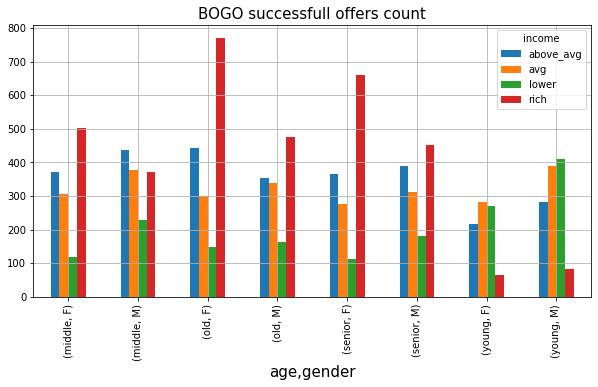

In [52]:
bogo_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==1]
a = bogo_success_df.groupby(['age', 'gender', 'income'])['age'].count().unstack()
a.plot.bar(figsize = (10,5), title = 'BOGO successfull offers count', grid = True)
a

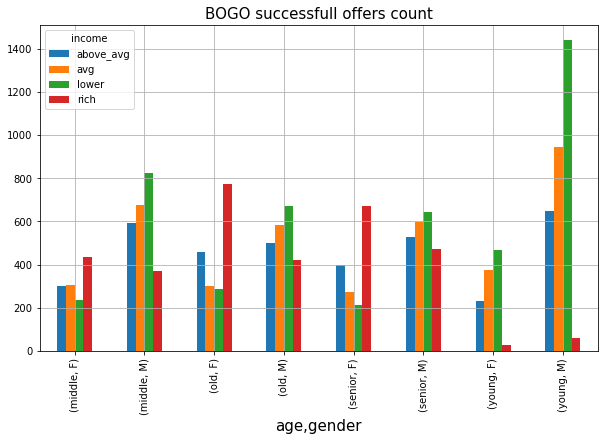

In [53]:
bogo_not_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==0]
b = bogo_not_success_df.groupby(['age', 'gender', 'income'])['age'].count().unstack()
b.plot.bar(figsize = (10,6),title = 'BOGO successfull offers count',  grid = True)


In [54]:
c = a+b
c

income         above_avg   avg  lower  rich
age    gender                              
middle F             674   611    358   939
       M            1030  1055   1054   744
old    F             903   601    436  1545
       M             851   923    836   894
senior F             765   547    325  1333
       M             914   909    824   921
young  F             449   657    738    94
       M             929  1331   1850   143

income         above_avg   avg  lower  rich
age    gender                              
middle F            55.0  50.0   34.0  53.0
       M            42.0  36.0   22.0  50.0
old    F            49.0  50.0   34.0  50.0
       M            41.0  37.0   20.0  53.0
senior F            48.0  50.0   35.0  50.0
       M            42.0  34.0   22.0  49.0
young  F            49.0  43.0   37.0  70.0
       M            30.0  29.0   22.0  57.0

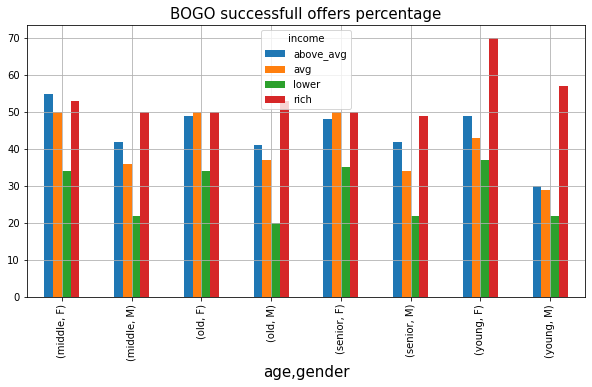

In [55]:
percentage_offer_complete = np.round(a/c * 100, decimals = 0)
percentage_offer_complete.plot.bar(figsize = (10,5),title = 'BOGO successfull offers percentage', grid = True)
percentage_offer_complete

From above graphs we can wee that the Females prefer BOGO more than men. If you will look at the graphs carefully, you will see that Rich category has offer completion percentage of nearly 45% - 55% for all the demographic groups and females in the age group of senior and old makes most number of purchases for BOGO offers. So we will say that Rich, females in the age group of Senior and old like BOGO offers more.

This doesnot give a very clear picture of which type of offer is prefered by the members. Lets deep dive into BOGO offers and see which of the four bogo offers were prefered more by customers by the customers.
Also we have seen that females make more purchases than males so now we will remove the gender category and concentrate on age and income.

offer_id
1.0    6590
2.0    6521
4.0    6584
9.0    6488
Name: offer_id, dtype: int64


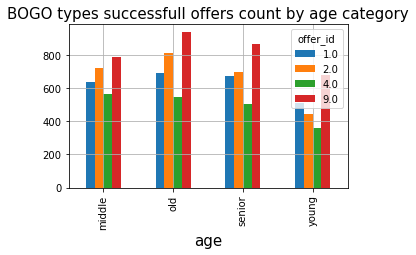

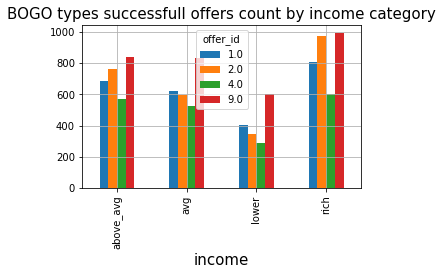

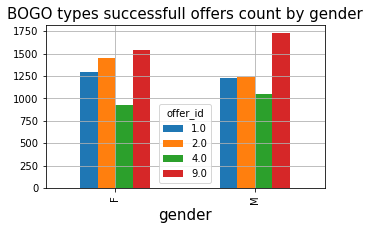

In [56]:
print(bogo_offers_df.groupby('offer_id')['offer_id'].count())
#bogo_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==1]
bogo_type_age_success_count = bogo_success_df.groupby(['age', 'offer_id'])['age'].count().unstack()
bogo_type_age_success_count.plot.bar(figsize = (5,3), title = 'BOGO types successfull offers count by age category', grid = True)
bogo_type_income_success_count = bogo_success_df.groupby(['income', 'offer_id'])['age'].count().unstack()
bogo_type_income_success_count.plot.bar(figsize = (5,3), title = 'BOGO types successfull offers count by income category', grid = True)
bogo_type_gender_success_count = bogo_success_df.groupby(['gender', 'offer_id'])['age'].count().unstack()
bogo_type_gender_success_count.plot.bar(figsize = (5,3), title = 'BOGO types successfull offers count by gender', grid = True)

#bogo_not_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==0]
bogo_type_age_not_success_count = bogo_not_success_df.groupby(['age', 'offer_id'])['age'].count().unstack()
bogo_type_income_not_success_count = bogo_not_success_df.groupby(['income', 'offer_id'])['age'].count().unstack()
bogo_type_gender_not_success_count = bogo_not_success_df.groupby(['gender', 'offer_id'])['age'].count().unstack()

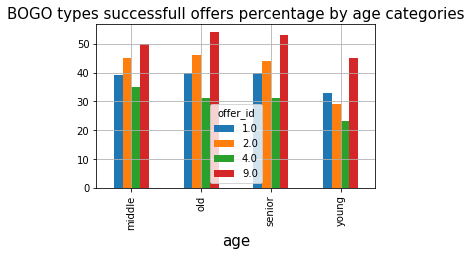

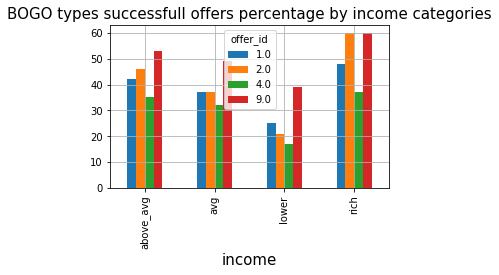

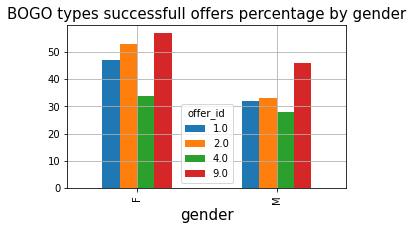

In [57]:
percentage_offer_age_type_complete = np.round((bogo_type_age_success_count/(bogo_type_age_success_count+bogo_type_age_not_success_count)) * 100, decimals = 0)
percentage_offer_age_type_complete.plot.bar(figsize = (5,3),title = 'BOGO types successfull offers percentage by age categories', grid = True)
percentage_offer_income_type_complete = np.round((bogo_type_income_success_count/(bogo_type_income_success_count+bogo_type_income_not_success_count)) * 100, decimals = 0)
percentage_offer_income_type_complete.plot.bar(figsize = (5,3),title = 'BOGO types successfull offers percentage by income categories', grid = True)
percentage_offer_gender_type_complete = np.round((bogo_type_gender_success_count/(bogo_type_gender_success_count+bogo_type_gender_not_success_count)) * 100, decimals = 0)
percentage_offer_gender_type_complete.plot.bar(figsize = (5,3),title = 'BOGO types successfull offers percentage by gender', grid = True)


Clearly offer 9 pis favorite amongst customers.

Now we will create a machine learning model to pridict which offers sent to customers will be successfully completed. To comlete this task I will create 3 model using 1. Logistics regression , 2. Random forrest classifier and AdaBoost classifier. Once I have initial benchmark of accuracy and F1 score, I will further tune these models and after that we will choose the one with best accuracy and F1 score.

We will give F1 score more preference as it is a more balance scale and gives weightage to both precision and recall.

In [58]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53201 entries, 0 to 272760
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index_new           53201 non-null  int32  
 1   member_id           53201 non-null  float64
 2   event               53201 non-null  object 
 3   time                53201 non-null  int64  
 4   offer_id            53201 non-null  float64
 5   transaction_amount  53201 non-null  float64
 6   transaction_reward  53201 non-null  float64
 7   gender              53201 non-null  object 
 8   age_num             53201 non-null  int64  
 9   income_num          53201 non-null  float64
 10  member_for_months   53201 non-null  int32  
 11  loyalty             53201 non-null  object 
 12  age                 53201 non-null  object 
 13  income              53201 non-null  object 
 14  offer_reward        53201 non-null  float64
 15  difficulty          53201 non-null  float64
 16  dur

In [59]:
model1_df = model_df.copy()

In [60]:
drop_cols = ['index_new', 'member_id', 'event', 'offer_id', 'transaction_amount', 'transaction_reward', 'loyalty', 'age',
           'income', 'view_successfull', 'time']
model1_df = model1_df.drop(drop_cols, axis = 1)
model1_df

,gender,age_num,income_num,member_for_months,offer_reward,difficulty,duration,offer_type,email,mobile,social,web,offer_successfull
0,F,75,100000.0,43,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0
10,F,75,100000.0,43,10.0,10.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0
12,F,75,100000.0,43,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0
18,M,68,70000.0,31,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0
23,M,68,70000.0,31,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272748,M,58,57000.0,39,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0
272752,M,48,58000.0,30,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0
272754,M,48,58000.0,30,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0
272758,M,47,94000.0,38,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0


In [61]:
#gender dummy
gender = pd.get_dummies(model1_df['gender'],prefix = "gender", prefix_sep = "-")
model1_df = pd.concat([model1_df,gender],axis=1)

#offer_type dummy
offer_type = pd.get_dummies(model1_df['offer_type'],prefix = "offer_type", prefix_sep = "-")
model1_df = pd.concat([model1_df,offer_type],axis=1)

model1_df

,gender,age_num,income_num,member_for_months,offer_reward,difficulty,duration,offer_type,email,mobile,social,web,offer_successfull,gender-F,gender-M,gender-O,offer_type-bogo,offer_type-discount
0,F,75,100000.0,43,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0,1,0,0,1,0
10,F,75,100000.0,43,10.0,10.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,1,0,0,1,0
12,F,75,100000.0,43,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,1,0,0,1,0
18,M,68,70000.0,31,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0,0,1,0,0,1
23,M,68,70000.0,31,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0,1.0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272748,M,58,57000.0,39,5.0,5.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,0,1,0,1,0
272752,M,48,58000.0,30,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,0,1,0,1,0
272754,M,48,58000.0,30,2.0,10.0,168.0,discount,1.0,1.0,0.0,1.0,0.0,0,1,0,0,1
272758,M,47,94000.0,38,10.0,10.0,120.0,bogo,1.0,1.0,1.0,1.0,0.0,0,1,0,1,0


In [62]:
model1_df = model1_df.drop(['gender', 'offer_type'], axis = 1)
model1_df

,age_num,income_num,member_for_months,offer_reward,difficulty,duration,email,mobile,social,web,offer_successfull,gender-F,gender-M,gender-O,offer_type-bogo,offer_type-discount
0,75,100000.0,43,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,1,0,0,1,0
10,75,100000.0,43,10.0,10.0,168.0,1.0,1.0,1.0,0.0,1.0,1,0,0,1,0
12,75,100000.0,43,5.0,5.0,120.0,1.0,1.0,1.0,1.0,0.0,1,0,0,1,0
18,68,70000.0,31,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,1
23,68,70000.0,31,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272748,58,57000.0,39,5.0,5.0,120.0,1.0,1.0,1.0,1.0,0.0,0,1,0,1,0
272752,48,58000.0,30,10.0,10.0,120.0,1.0,1.0,1.0,1.0,0.0,0,1,0,1,0
272754,48,58000.0,30,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,1
272758,47,94000.0,38,10.0,10.0,120.0,1.0,1.0,1.0,1.0,0.0,0,1,0,1,0


In [74]:
X = model1_df.drop('offer_successfull', axis = 1)
Y = model1_df['offer_successfull']
#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
scaler = StandardScaler()
X_train_scale=scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_scale,Y_train)
y_pred = lr.predict(X_test_scale)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73      7747
         1.0       0.62      0.51      0.56      5554

    accuracy                           0.67     13301
   macro avg       0.66      0.64      0.65     13301
weighted avg       0.66      0.67      0.66     13301

0.5624012638230647


0.6667919705285317

In [64]:
model2_df = model_df.copy()

In [65]:
model2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53201 entries, 0 to 272760
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index_new           53201 non-null  int32  
 1   member_id           53201 non-null  float64
 2   event               53201 non-null  object 
 3   time                53201 non-null  int64  
 4   offer_id            53201 non-null  float64
 5   transaction_amount  53201 non-null  float64
 6   transaction_reward  53201 non-null  float64
 7   gender              53201 non-null  object 
 8   age_num             53201 non-null  int64  
 9   income_num          53201 non-null  float64
 10  member_for_months   53201 non-null  int32  
 11  loyalty             53201 non-null  object 
 12  age                 53201 non-null  object 
 13  income              53201 non-null  object 
 14  offer_reward        53201 non-null  float64
 15  difficulty          53201 non-null  float64
 16  dur

In [66]:
drop_cols = ['index_new', 'member_id', 'event','time','offer_id', 'transaction_amount', 'transaction_reward', 'member_for_months'
             , 'age_num','income_num', 'view_successfull']
model2_df = model2_df.drop(drop_cols, axis = 1)

#gender dummy
gender = pd.get_dummies(model2_df['gender'],prefix = "gender", prefix_sep = "-")
model2_df = pd.concat([model2_df,gender],axis=1)

#age dummy
age = pd.get_dummies(model2_df['age'],prefix = "age", prefix_sep = "-")
model2_df = pd.concat([model2_df,age],axis=1)

#income dummy
income = pd.get_dummies(model2_df['income'],prefix = "income", prefix_sep = "-")
model2_df = pd.concat([model2_df,income],axis=1)

#loyalty dummy
loyalty = pd.get_dummies(model2_df['loyalty'],prefix = "loyalty", prefix_sep = "-")
model2_df = pd.concat([model2_df,loyalty],axis=1)

#offer_type dummy
offer_type = pd.get_dummies(model2_df['offer_type'],prefix = "offer_type", prefix_sep = "-")
model2_df = pd.concat([model2_df,offer_type],axis=1)

model2_df = model2_df.drop(['gender', 'offer_type', 'loyalty', 'income', 'age'], axis = 1)

X = model2_df.drop('offer_successfull', axis = 1)
Y = model2_df['offer_successfull']
#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75      7743
         1.0       0.65      0.55      0.60      5558

    accuracy                           0.69     13301
   macro avg       0.68      0.67      0.67     13301
weighted avg       0.69      0.69      0.68     13301

0.5976429336709848


0.6894218479813548

we will create the adaboost classifier with the data prepared for 1. Random forrest classifier

In [67]:
#Adaboost with Logistics regression data : model1_df
abc =AdaBoostClassifier(n_estimators=100, learning_rate=1)
abc.fit(X_train,Y_train)
y_pred = abc.predict(X_test)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)


              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75      7743
         1.0       0.65      0.54      0.59      5558

    accuracy                           0.69     13301
   macro avg       0.68      0.67      0.67     13301
weighted avg       0.68      0.69      0.68     13301

0.5911233307148468


0.6869408315164274

we can see that the random forrest is giving the best accuracy and F1 score for this probem.
Now lets try to improve the results a bit and check again.
First we will try to improve the Logistics regression model, by fine tuning hyperparameters

In [93]:
lrparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

LR_search = GridSearchCV(lr, param_grid=lrparam_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_search.fit(X_train_scale,Y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=lbfgs .................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("

[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=100, penalty=l1, solver=liblinear, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=100, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=100, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=100, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=100, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=100, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=100, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=100, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=100, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=100, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco


[CV] C=0.001, max_iter=200, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=200, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=200, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=200, penalty=l1, solver=sag ...................
[CV]  C=0.001, max

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=200, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=200, penalty=l1, solver=saga, score=0.421, total=   0.2s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=200, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=200, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco


[CV] C=0.001, max_iter=300, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=300, penalty=l1, solver=liblinear, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=300, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=300, penalty=l1, solver=sag ...................
[CV]  C=0.001, max

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.421, total=   0.2s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=300, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=300, penalty=l1, solver=saga, score=0.421, total=   0.2s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=300, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=300, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco


[CV] C=0.001, max_iter=400, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=liblinear, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=400, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=400, penalty=l1, solver=sag ...................
[CV]  C=0.001, max

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=400, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=400, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=400, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=400, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco


[CV] C=0.001, max_iter=500, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=liblinear, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=500, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=500, penalty=l1, solver=sag ...................
[CV]  C=0.001, max

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.421, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=500, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=500, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=500, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.001, max_iter=600, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=600, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=600, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=600, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=600, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=600, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.001, max_iter=700, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=liblinear .............
[CV]  C=0.001, max_iter=700, penalty=l1, solver=liblinear, score=0.579, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001, max_iter=700, penalty=l1, solver=sag ...................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.001

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.579, total=   0.1s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.579, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=700, penalty=l1, solver=saga ..................
[CV]  C=0.001, max_iter=700, penalty=l1, solver=saga, score=0.421, total=   0.1s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.001, max_iter=700, penalty=l2, solver=newton-cg .............
[CV]  C=0.001, max_iter=700, penalty=l2, solver=newton-cg, score=0.494, total=   0.

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=100, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=100, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=100, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.498, total=   0.4s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.499, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.499, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.515, total=   0.3s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=100, penalty=l1, solver=saga, score=0.503, total=   0.5s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.01, max_iter=100, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=100, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=200, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=200, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=200, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"



[CV] C=0.01, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.498, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.499, total=   0.4s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, penalty=l1, solver=saga, score=0.499, total=   0.3s
[CV] C=0.01, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=200, pen

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=300, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=300, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=300, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=300, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.498, total=   0.3s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.499, total=   0.4s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.499, total=   0.3s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.515, total=   0.3s
[CV] C=0.01, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=300, penalty=l1, solver=saga, score=0.503, total=   0.3s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.01, max_iter=300, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=300, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=400, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=400, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=400, penalty=l1, solver=sag ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.01, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.498, total=   0.4s
[CV] C=0.01, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=400, penalty=l1, solver=saga, score=0.499, total=   0.3s
[CV] C=0.01, max_iter=400, pe

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=500, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=500, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.498, total=   0.5s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.499, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.499, total=   0.4s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.515, total=   0.3s
[CV] C=0.01, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=500, penalty=l1, solver=saga, score=0.503, total=   0.3s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.01, max_iter=500, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=500, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=600, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=600, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=600, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=600, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=600, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=600, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.498, total=   0.4s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.499, total=   0.5s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.499, total=   0.3s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.515, total=   0.3s
[CV] C=0.01, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=600, penalty=l1, solver=saga, score=0.503, total=   0.3s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.494, total=   0.2s
[CV] C=0.01, max_iter=600, penalty=l2, solver=newton-cg ..............
[CV]  C=0.01, max_iter=600, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.01, max_iter=700, penalty=l1, solver=liblinear, score=0.499, total=   0.1s
[CV] C=0.01, max_iter=700, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=liblinear, score=0.515, total=   0.1s
[CV] C=0.01, max_iter=700, penalty=l1, solver=liblinear ..............
[CV]  C=0.01, max_iter=700, penalty=l1, solver=liblinear, score=0.501, total=   0.1s
[CV] C=0.01, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"



[CV] C=0.01, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.498, total=   0.4s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.499, total=   0.5s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=700, penalty=l1, solver=saga, score=0.499, total=   0.5s
[CV] C=0.01, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=0.01, max_iter=700, pen

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.491, total=   0.2s
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.515, total=   0.2s
[CV] C=0.1, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.493, total=   0.3s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=100, penalty=l1, solver=saga, score=0.494, total=   0.4s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=100, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.491, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.515, total=   0.3s
[CV] C=0.1, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=0.1, max_iter=200, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=200, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.493, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=200, penalty=l1, solver=saga, score=0.494, total=   0.4s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=200, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco


[CV] C=0.1, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=0.1, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=liblinear, score=0.515, total=   0.2s
[CV] C=0.1, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=300, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=300, penalty=l1, solver=sag .....................
[CV]  C=0.1, m

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.493, total=   0.4s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.496, total=   0.5s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.515, total=   0.5s
[CV] C=0.1, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=300, penalty=l1, solver=saga, score=0.494, total=   0.5s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=300, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=300, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.1, max_iter=400, penalty=l1, solver=liblinear, score=0.491, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=liblinear, score=0.515, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=0.1, max_iter=400, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=400, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.493, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=400, penalty=l1, solver=saga, score=0.494, total=   0.4s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=400, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=400, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.1, max_iter=500, penalty=l1, solver=liblinear, score=0.491, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=liblinear, score=0.496, total=   0.1s
[CV] C=0.1, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=liblinear, score=0.515, total=   0.3s
[CV] C=0.1, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=0.1, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.493, total=   0.5s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=500, penalty=l1, solver=saga, score=0.494, total=   0.4s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=500, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=500, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=0.1, max_iter=600, penalty=l1, solver=liblinear, score=0.491, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=liblinear, score=0.515, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=600, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.493, total=   0.4s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.496, total=   0.3s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=0.1, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=600, penalty=l1, solver=saga, score=0.494, total=   0.3s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=600, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=600, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco


[CV] C=0.1, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=liblinear, score=0.493, total=   0.1s
[CV] C=0.1, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=liblinear, score=0.515, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=0.1, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=sag .....................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, max_iter=700, penalty=l1, solver=sag .....................
[CV]  C=0.1, m

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.493, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=0.1, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=0.1, max_iter=700, penalty=l1, solver=saga, score=0.494, total=   0.3s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=0.1, max_iter=700, penalty=l2, solver=newton-cg ...............
[CV]  C=0.1, max_iter=700, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=0.1,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=100, penalty=l1, solver=liblinear, score=0.494, total=   0.4s
[CV] C=1, max_iter=100, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=100, penalty=l1, solver=liblinear, score=0.490, total=   0.3s
[CV] C=1, max_iter=100, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=100, penalty=l1, solver=liblinear, score=0.496, total=   1.0s
[CV] C=1, max_iter=100, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=100, penalty=l1, solver=liblinear, score=0.517, total=   0.5s
[CV] C=1, max_iter=100, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=100, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=1, max_iter=100, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=100, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   0.3s
[CV] C=1, max_iter=100, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.490, total=   0.4s
[CV] C=1, max_iter=100, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.496, total=   0.3s
[CV] C=1, max_iter=100, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.516, total=   0.4s
[CV] C=1, max_iter=100, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=100, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.496, total=   0.2s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=100, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=1, max_iter=100, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=200, penalty=l1, solver=liblinear, score=0.494, total=   0.3s
[CV] C=1, max_iter=200, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=200, penalty=l1, solver=liblinear, score=0.490, total=   0.8s
[CV] C=1, max_iter=200, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=200, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1, max_iter=200, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=200, penalty=l1, solver=liblinear, score=0.517, total=   0.8s
[CV] C=1, max_iter=200, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=200, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=1, max_iter=200, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=200, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.490, total=   0.4s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=1, max_iter=200, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=200, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.496, total=   0.3s
[CV] C=1, max_iter=200, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=200, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=1, max_iter=200, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=300, penalty=l1, solver=liblinear, score=0.494, total=   0.5s
[CV] C=1, max_iter=300, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=300, penalty=l1, solver=liblinear, score=0.490, total=   1.0s
[CV] C=1, max_iter=300, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=300, penalty=l1, solver=liblinear, score=0.496, total=   0.7s
[CV] C=1, max_iter=300, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=300, penalty=l1, solver=liblinear, score=0.517, total=   0.8s
[CV] C=1, max_iter=300, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=300, penalty=l1, solver=liblinear, score=0.496, total=   0.3s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=300, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   0.3s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.490, total=   0.5s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.516, total=   0.4s
[CV] C=1, max_iter=300, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=300, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.496, total=   0.2s
[CV] C=1, max_iter=300, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=300, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=1, max_iter=300, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=400, penalty=l1, solver=liblinear, score=0.494, total=   0.4s
[CV] C=1, max_iter=400, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=400, penalty=l1, solver=liblinear, score=0.490, total=   0.4s
[CV] C=1, max_iter=400, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=400, penalty=l1, solver=liblinear, score=0.496, total=   1.4s
[CV] C=1, max_iter=400, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=400, penalty=l1, solver=liblinear, score=0.517, total=   0.4s
[CV] C=1, max_iter=400, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=400, penalty=l1, solver=liblinear, score=0.496, total=   0.3s
[CV] C=1, max_iter=400, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=400, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   0.5s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.490, total=   0.4s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.516, total=   0.3s
[CV] C=1, max_iter=400, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=400, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.496, total=   0.2s
[CV] C=1, max_iter=400, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=400, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=1, max_iter=400, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=500, penalty=l1, solver=liblinear, score=0.494, total=   0.6s
[CV] C=1, max_iter=500, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=500, penalty=l1, solver=liblinear, score=0.490, total=   0.4s
[CV] C=1, max_iter=500, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=500, penalty=l1, solver=liblinear, score=0.496, total=   0.2s
[CV] C=1, max_iter=500, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=500, penalty=l1, solver=liblinear, score=0.517, total=   1.0s
[CV] C=1, max_iter=500, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=500, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1, max_iter=500, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=500, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.490, total=   0.4s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.496, total=   0.5s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=1, max_iter=500, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=500, penalty=l1, solver=saga, score=0.496, total=   0.3s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.496, total=   0.2s
[CV] C=1, max_iter=500, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=500, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=1, max_iter=500, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=600, penalty=l1, solver=liblinear, score=0.494, total=   0.4s
[CV] C=1, max_iter=600, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=600, penalty=l1, solver=liblinear, score=0.490, total=   0.8s
[CV] C=1, max_iter=600, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=600, penalty=l1, solver=liblinear, score=0.496, total=   1.1s
[CV] C=1, max_iter=600, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=600, penalty=l1, solver=liblinear, score=0.517, total=   0.4s
[CV] C=1, max_iter=600, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=600, penalty=l1, solver=liblinear, score=0.496, total=   0.3s
[CV] C=1, max_iter=600, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=600, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.490, total=   0.4s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.516, total=   0.4s
[CV] C=1, max_iter=600, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=600, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.496, total=   0.2s
[CV] C=1, max_iter=600, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=600, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=1, max_iter=600, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1, max_iter=700, penalty=l1, solver=liblinear, score=0.494, total=   0.3s
[CV] C=1, max_iter=700, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=700, penalty=l1, solver=liblinear, score=0.490, total=   0.3s
[CV] C=1, max_iter=700, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=700, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1, max_iter=700, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=700, penalty=l1, solver=liblinear, score=0.517, total=   0.5s
[CV] C=1, max_iter=700, penalty=l1, solver=liblinear .................
[CV]  C=1, max_iter=700, penalty=l1, solver=liblinear, score=0.496, total=   0.5s
[CV] C=1, max_iter=700, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_iter=700, penalty=l1, solver=sag .......................
[CV]  C=1, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1, max_it

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.490, total=   0.5s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.516, total=   0.4s
[CV] C=1, max_iter=700, penalty=l1, solver=saga ......................
[CV]  C=1, max_iter=700, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.496, total=   0.2s
[CV] C=1, max_iter=700, penalty=l2, solver=newton-cg .................
[CV]  C=1, max_iter=700, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=1, max_iter=700, p

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=10, max_iter=100, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=100, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=10, max_iter=100, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   1.7s
[CV] C=10, max_iter=100, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=100, penalty=l1, solver=liblinear, score=0.516, total=   0.5s
[CV] C=10, max_iter=100, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=100, penalty=l1, solver=liblinear, score=0.496, total=   0.9s
[CV] C=10, max_iter=100, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   0.6s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.491, total=   0.5s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   0.7s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=100, penalty=l1, solver=saga, score=0.496, total=   0.5s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=100, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   0.8s
[CV] C=10, max_iter=200, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=200, penalty=l1, solver=liblinear, score=0.491, total=   1.8s
[CV] C=10, max_iter=200, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   2.0s
[CV] C=10, max_iter=200, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=200, penalty=l1, solver=liblinear, score=0.516, total=   2.7s
[CV] C=10, max_iter=200, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=200, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=10, max_iter=200, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=200, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   0.8s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=10, max_iter=200, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=200, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=10, max_iter=200, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=200, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   2.1s
[CV] C=10, max_iter=300, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=300, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=10, max_iter=300, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=10, max_iter=300, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=300, penalty=l1, solver=liblinear, score=0.516, total=   3.6s
[CV] C=10, max_iter=300, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=300, penalty=l1, solver=liblinear, score=0.496, total=   0.7s
[CV] C=10, max_iter=300, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=300, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   0.6s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=10, max_iter=300, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=300, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=10, max_iter=300, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=300, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   0.8s
[CV] C=10, max_iter=400, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=400, penalty=l1, solver=liblinear, score=0.491, total=   2.1s
[CV] C=10, max_iter=400, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   1.9s
[CV] C=10, max_iter=400, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=400, penalty=l1, solver=liblinear, score=0.516, total=   1.7s
[CV] C=10, max_iter=400, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=400, penalty=l1, solver=liblinear, score=0.496, total=   1.6s
[CV] C=10, max_iter=400, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=400, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.491, total=   0.5s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   0.7s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.516, total=   0.4s
[CV] C=10, max_iter=400, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=400, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=10, max_iter=400, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=400, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   1.9s
[CV] C=10, max_iter=500, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=500, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=10, max_iter=500, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   0.6s
[CV] C=10, max_iter=500, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=500, penalty=l1, solver=liblinear, score=0.516, total=   1.7s
[CV] C=10, max_iter=500, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=500, penalty=l1, solver=liblinear, score=0.496, total=   1.0s
[CV] C=10, max_iter=500, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=500, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   0.5s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   0.7s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.516, total=   0.6s
[CV] C=10, max_iter=500, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=500, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.495, total=   0.3s
[CV] C=10, max_iter=500, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=500, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   1.8s
[CV] C=10, max_iter=600, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=600, penalty=l1, solver=liblinear, score=0.491, total=   1.7s
[CV] C=10, max_iter=600, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   1.6s
[CV] C=10, max_iter=600, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=600, penalty=l1, solver=liblinear, score=0.516, total=   0.4s
[CV] C=10, max_iter=600, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=600, penalty=l1, solver=liblinear, score=0.496, total=   1.7s
[CV] C=10, max_iter=600, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=600, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.491, total=   0.5s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   0.9s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=10, max_iter=600, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=600, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=10, max_iter=600, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=600, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=10, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=10, max_iter=700, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=700, penalty=l1, solver=liblinear, score=0.491, total=   1.8s
[CV] C=10, max_iter=700, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   1.7s
[CV] C=10, max_iter=700, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=700, penalty=l1, solver=liblinear, score=0.516, total=   1.4s
[CV] C=10, max_iter=700, penalty=l1, solver=liblinear ................
[CV]  C=10, max_iter=700, penalty=l1, solver=liblinear, score=0.496, total=   0.8s
[CV] C=10, max_iter=700, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10, max_iter=700, penalty=l1, solver=sag ......................
[CV]  C=10, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=10

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   0.3s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   0.8s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.516, total=   0.5s
[CV] C=10, max_iter=700, penalty=l1, solver=saga .....................
[CV]  C=10, max_iter=700, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=10, max_iter=700, penalty=l2, solver=newton-cg ................
[CV]  C=10, max_iter=700, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=10, max_ite

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=100, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=liblinear, score=0.491, total=   0.5s
[CV] C=100, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=100, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=liblinear, score=0.515, total=   0.7s
[CV] C=100, max_iter=100, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=100, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=100, max_iter=100, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=100, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaconda3\l

[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   1.5s
[CV] C=100, max_iter=100, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.491, total=   1.3s
[CV] C=100, max_iter=100, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   1.4s
[CV] C=100, max_iter=100, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.515, total=   1.1s
[CV] C=100, max_iter=100, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=100, penalty=l1, solver=saga, score=0.496, total=   1.0s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.515, total=   0.2s
[CV] C=100, max_iter=100, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=100, penalty=l2, solver=newton-cg, score=0.496, total=   0

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=100, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=liblinear, score=0.491, total=   0.6s
[CV] C=100, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=100, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=liblinear, score=0.515, total=   0.5s
[CV] C=100, max_iter=200, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=200, penalty=l1, solver=liblinear, score=0.496, total=   0.7s
[CV] C=100, max_iter=200, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=200, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   1.5s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.491, total=   1.6s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   2.5s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.515, total=   2.7s
[CV] C=100, max_iter=200, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=200, penalty=l1, solver=saga, score=0.496, total=   1.3s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.495, total=   0.3s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.515, total=   0.2s
[CV] C=100, max_iter=200, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=200, penalty=l2, solver=newton-cg, score=0.496, total=   0

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=100, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=100, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   0.8s
[CV] C=100, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=100, max_iter=300, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=300, penalty=l1, solver=liblinear, score=0.496, total=   0.5s
[CV] C=100, max_iter=300, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=300, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   2.0s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.491, total=   1.4s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   3.4s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.515, total=   3.1s
[CV] C=100, max_iter=300, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=300, penalty=l1, solver=saga, score=0.496, total=   1.1s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=300, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=300, penalty=l2, solver=newton-cg, score=0.515, total=   0.2s
[

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=100, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=liblinear, score=0.491, total=   0.5s
[CV] C=100, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   0.9s
[CV] C=100, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=liblinear, score=0.515, total=   0.5s
[CV] C=100, max_iter=400, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=400, penalty=l1, solver=liblinear, score=0.496, total=   0.5s
[CV] C=100, max_iter=400, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=400, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   1.9s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.491, total=   1.5s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   5.1s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.515, total=   2.9s
[CV] C=100, max_iter=400, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=400, penalty=l1, solver=saga, score=0.496, total=   1.0s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=400, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=400, penalty=l2, solver=newton-cg, score=0.515, total=   0.2s
[

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=100, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=100, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=100, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=liblinear, score=0.515, total=   1.7s
[CV] C=100, max_iter=500, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=500, penalty=l1, solver=liblinear, score=0.496, total=   0.6s
[CV] C=100, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=500, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   2.2s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.491, total=   1.5s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   4.3s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.515, total=   2.7s
[CV] C=100, max_iter=500, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=500, penalty=l1, solver=saga, score=0.496, total=   1.0s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=500, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=500, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=100,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   1.3s
[CV] C=100, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=liblinear, score=0.491, total=   0.5s
[CV] C=100, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=100, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=100, max_iter=600, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=600, penalty=l1, solver=liblinear, score=0.496, total=   3.2s
[CV] C=100, max_iter=600, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=600, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   1.6s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.491, total=   1.5s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   4.8s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.515, total=   2.7s
[CV] C=100, max_iter=600, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=600, penalty=l1, solver=saga, score=0.496, total=   1.0s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=600, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=600, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV] C=100,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=100, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=100, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=100, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=100, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=100, max_iter=700, penalty=l1, solver=liblinear ...............
[CV]  C=100, max_iter=700, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=100, max_iter=700, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=100, max_iter=700, penalty=l1, solver=sag .....................
[CV]  C=100, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[C

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   1.4s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.491, total=   1.2s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   4.3s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.515, total=   2.7s
[CV] C=100, max_iter=700, penalty=l1, solver=saga ....................
[CV]  C=100, max_iter=700, penalty=l1, solver=saga, score=0.496, total=   1.0s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=100, max_iter=700, penalty=l2, solver=newton-cg ...............
[CV]  C=100, max_iter=700, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV] C=100,

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=liblinear, score=0.491, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=100, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=100, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=100, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=100, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.495, total=   0.3s
[CV] C=1000, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=100, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=100, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=100, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=liblinear, score=0.491, total=   0.5s
[CV] C=1000, max_iter=200, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=200, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=200, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=200, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=200, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=200, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   0.5s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.491, total=   0.5s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.515, total=   0.5s
[CV] C=1000, max_iter=200, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=200, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=200, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=200, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=300, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=300, penalty=l1, solver=liblinear, score=0.496, total=   0.5s
[CV] C=1000, max_iter=300, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=300, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=300, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=300, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=300, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=300, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=300, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=400, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=liblinear, score=0.495, total=   0.2s
[CV] C=1000, max_iter=400, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=400, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=400, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=400, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=400, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.515, total=   0.3s
[CV] C=1000, max_iter=400, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=400, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=400, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=400, penalty=l2, solver=newton-cg, score=0.491, total=   0.2s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=500, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=liblinear, score=0.495, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=500, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=500, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=500, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=500, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.515, total=   0.3s
[CV] C=1000, max_iter=500, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=500, penalty=l1, solver=saga, score=0.496, total=   0.3s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=500, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=500, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=600, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=600, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=600, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=600, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=600, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=600, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=600, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=600, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV]

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shashi.S.Singh\Anaco

[CV]  C=1000, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=liblinear, score=0.491, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=liblinear, score=0.495, total=   0.3s
[CV] C=1000, max_iter=700, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=liblinear, score=0.515, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=liblinear ..............
[CV]  C=1000, max_iter=700, penalty=l1, solver=liblinear, score=0.496, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=700, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1000, max_iter=700, penalty=l1, solver=sag ....................
[CV]  C=1000, max_iter=700, penalty=l1, solver=sag, score=nan, total=   

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.491, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.495, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.515, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l1, solver=saga ...................
[CV]  C=1000, max_iter=700, penalty=l1, solver=saga, score=0.496, total=   0.4s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.495, total=   0.2s
[CV] C=1000, max_iter=700, penalty=l2, solver=newton-cg ..............
[CV]  C=1000, max_iter=700, penalty=l2, solver=newton-cg, score=0.491, total=   0.1s
[CV]

[Parallel(n_jobs=1)]: Done 2450 out of 2450 | elapsed:  9.5min finished


In [76]:
lr = LogisticRegression(C = 0.001, max_iter= 100, penalty= 'l1', solver= 'liblinear')
lr.fit(X_train_scale,Y_train)
y_pred = lr.predict(X_test_scale)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73      7747
         1.0       0.62      0.54      0.58      5554

    accuracy                           0.67     13301
   macro avg       0.66      0.65      0.65     13301
weighted avg       0.67      0.67      0.67     13301

0.5759040804486559


0.6702503571160063

Not much improvement in the logistics regression. Now lets try to improve the random forrest classifer

In [ ]:
clfparam_grid = {'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [50,100,200,300,400 ],
                'min_samples_split': [25, 50, 75, 100, 125,150],
                'min_samples_leaf': [2,10,15,20]
                }

CLF_search = GridSearchCV(clf, param_grid=clfparam_grid, verbose = 3, cv=5)

# fitting the model for grid search 
CLF_search.fit(X_train,Y_train)
CLF_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % CLF_search.best_score_)
print('Config: %s' % CLF_search.best_params_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50, score=0.689, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50, score=0.694, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50, score=0.689, total=   0.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50, score=0.690, total=   0.8s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=50, score=0.692, total=   0.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=100, score=0.686, total=   1.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=100, score=0.695, total=

[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.695, total=   1.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300, score=0.687, total=   3.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300, score=0.695, total=   4.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300, score=0.687, total=   4.0s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=300, score=0.689, t

[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50, score=0.695, total=   0.8s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50, score=0.691, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50, score=0.689, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=50, score=0.696, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=100, score=0.688,

[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score=0.688, total=   1.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score=0.695, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=300, score=0.687, total=   3.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=300, score=0.694, total=   3.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=300, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50, score=0.687, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50, score=0.694, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50, score=0.690, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50, score=0.690, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=50, score=0.693, t

[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.688, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.688, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.695, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=300, score=0.687, total=   4.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=300, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=400, score=0.693, total=   5.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50, score=0.685, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50, score=0.695, total=   0.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50, score=0.691, total=   0.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=50, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100, score=0.693, total=   2.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100, score=0.690, total=   2.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100, score=0.687, total=   2.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=100, score=0.695, total=   2.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=300 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=125, n_estimators=3

[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=400, score=0.690, total=   8.8s
[CV] max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=400, score=0.692, total=   8.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=50, score=0.684, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=50, score=0.696, total=   1.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=50, score=0.

[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score=0.685, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score=0.695, total=   2.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score=0.688, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score=0.688, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=400, score=0.687, total=   4.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=400, score=0.690, total=   4.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=400, score=0.693, total=   4.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=50, score=0.686, total=   0.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=50, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100, score=0.696, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100, score=0.685, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100, score=0.693, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100, score=0.690, total=   1.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=125, n_estimators=1

[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400, score=0.693, total=   5.0s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400, score=0.689, total=   5.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400, score=0.690, total=   5.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=400, score=0.692, total=   5.9s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=50, 

[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100, score=0.687, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100, score=0.694, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100, score=0.686, total=   1.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100, score=0.694, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=50, n_estimators=100, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400, score=0.686, total=   5.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400, score=0.693, total=   5.5s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400, score=0.688, total=   5.0s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400, score=0.690, total=   5.7s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=75, n_estimators=400, score

[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100, score=0.690, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100, score=0.687, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100, score=0.695, total=   1.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100, score=0.686, total=   1.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=125, n_estimators=1

[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=300, score=0.692, total=   5.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400, score=0.686, total=   5.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400, score=0.693, total=   5.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400, score=0.689, total=   5.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=150, n_estimators=4

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.694, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.689, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.688, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.695, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.687, t

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=300, score=0.690, total=   3.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=300, score=0.693, total=   4.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=400, score=0.686, total=   5.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=400, score=0.693, total=   5.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=75, n_estimators=400, score=0.687, t

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score=0.686, total=   1.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score=0.693, total=   1.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score=0.689, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score=0.688, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=125, n_estimators=100, score

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=300, score=0.691, total=   3.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=300, score=0.690, total=   4.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=300, score=0.693, total=   4.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=400, score=0.686, total=   4.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=400 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=150, n_estimators=400, score

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.694, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.685, total=   1.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.694, total=   1.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.688, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300, score=0.694, total=   3.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300, score=0.689, total=   4.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300, score=0.690, total=   3.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=300, score=0.693, total=   3.9s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=400 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=75, n_estimators=400, score

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=50, score=0.688, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=50, score=0.697, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=100, score=0.687, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=100, score=0.693, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=125, n_estimators=100,

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300, score=0.687, total=   3.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300, score=0.694, total=   3.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300, score=0.690, total=   4.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300, score=0.690, total=   3.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=150, n_estimators=3

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=50, score=0.688, total=   0.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=50, score=0.690, total=   1.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=50, score=0.694, total=   1.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score=0.685, total=   1.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100, score=0.69

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=100, score=0.694, total=   1.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300, score=0.686, total=   4.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300, score=0.694, total=   3.9s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300, score=0.689, total=   3.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=75, n_estimators=300, score

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50, score=0.697, total=   0.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50, score=0.691, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50, score=0.690, total=   0.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=50, score=0.697, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=125, n_estimators=100, sco

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=100, score=0.689, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=100, score=0.695, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=300, score=0.688, total=   3.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=300, score=0.694, total=   3.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=15, min_samples_split=150, n_estimators=3

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.687, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.695, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.688, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.689, total=   0.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.695, t

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=100, score=0.687, total=   1.5s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=100, score=0.687, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=100, score=0.694, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=300, score=0.687, total=   4.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=75, n_estimators=300, score

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=100, n_estimators=400, score=0.694, total=   5.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50, score=0.687, total=   0.8s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50, score=0.695, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50, score=0.691, total=   0.6s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=125, n_estimators=50, scor

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100, score=0.693, total=   1.4s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100, score=0.690, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100, score=0.691, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=100, score=0.695, total=   1.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=300 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=150, n_estimators=3

[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=400, score=0.696, total=   8.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=25, n_estimators=400, score=0.705, total=   8.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=50, score=0.691, total=   1.1s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=50, score=0.698, total=   1.1s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=50, n_estimators=50, score=0.700

[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100, score=0.690, total=   1.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100, score=0.695, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100, score=0.700, total=   2.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100, score=0.696, total=   2.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=75, n_estimators=100, score

[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=400, score=0.702, total=   7.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=400, score=0.697, total=   8.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=100, n_estimators=400, score=0.703, total=   7.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=50 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=50, score=0.691, total=   1.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=50 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=125, n_estimators=50, 

[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100, score=0.702, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100, score=0.691, total=   2.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100, score=0.697, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100, score=0.700, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=150, n_estimators=1

[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400, score=0.697, total=   7.9s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400, score=0.702, total=   8.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400, score=0.697, total=   8.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=25, n_estimators=400, score=0.704, total=   8.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=50

[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100, score=0.697, total=   2.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100, score=0.701, total=   2.1s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100, score=0.691, total=   2.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100, score=0.697, total=   2.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=75, n_estimators=1

[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400, score=0.692, total=   8.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400, score=0.697, total=   8.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400, score=0.703, total=   9.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400, score=0.696, total=   9.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_est

[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100, score=0.700, total=   1.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100, score=0.697, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100, score=0.702, total=   2.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100, score=0.692, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=150, n_est

[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=300, score=0.704, total=   5.9s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400, score=0.692, total=   7.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400, score=0.694, total=   7.5s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400, score=0.702, total=   7.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=4

[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100, score=0.696, total=   1.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100, score=0.699, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100, score=0.697, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100, score=0.702, total=   1.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=75, n_estimators=1

[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=300, score=0.697, total=   5.9s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=300, score=0.701, total=   5.8s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=400, score=0.690, total=   8.0s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=400, score=0.695, total=   7.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=100, n_est

[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100, score=0.691, total=   1.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100, score=0.696, total=   1.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100, score=0.697, total=   1.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100, score=0.696, total=   1.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_estimators=100 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=150, n_est

[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=300, score=0.701, total=   5.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=300 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=300, score=0.697, total=   5.9s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=300 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=300, score=0.702, total=   6.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=400, score=0.692, total=   8.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=400 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=4

In [79]:
clf = RandomForestClassifier(max_depth=10, max_features='auto', min_samples_leaf=15, min_samples_split=25,
                             n_estimators=100,random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))
print(f1_score(Y_test,y_pred))
accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76      7747
         1.0       0.68      0.54      0.60      5554

    accuracy                           0.70     13301
   macro avg       0.70      0.68      0.68     13301
weighted avg       0.70      0.70      0.70     13301

0.6038190954773869


0.7036313059168483

Below we will do the k-fold cross validation to illustrate robustness of our model.

In [84]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(clf, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.700 (0.007)


We can see that the mean accuracy score in 70% and standard deviation is .7 which is low this means that our model produces same results for all kind variations in train and test data. 

there is some improvement in the Random forrest calssifier as well. Given the small set of data we have and few variables, I see that this is a good model. of course there is scope for improvement and wth more advanced supervised models like XGBoost and  model 